In [1]:
import json
import math
import random
from collections import defaultdict
from dataclasses import dataclass, field
from pathlib import Path
from shutil import copy2
from typing import *
from scipy.stats import halfnorm
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
import sys
import os
from loremipsum import generate_paragraphs
from loremipsum import generate_paragraph
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
import albumentations as A

# from detectron2.added_utils.get_templates import create_templates
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.added_utils.get_dataset_stats import *

In [2]:
@dataclass
class Bbox:
    xmin: float
    ymin: float
    xmax: float
    ymax: float
    label: Optional[str] = None

    @property
    def width(self) -> float:
        return self.xmax - self.xmin

    @property
    def height(self) -> float:
        return self.ymax - self.ymin

    @property
    def center(self) -> Tuple[float, float]:
        mid_x = (self.xmin + self.xmax) / 2
        mid_y = (self.ymin + self.ymax) / 2

        return mid_x, mid_y

    def as_tuple(self) -> Tuple[float, float, float, float]:
        return self.xmin, self.ymin, self.xmax, self.ymax

    def as_tuple_int(self) -> Tuple[int, int, int, int]:
        return (
            math.floor(self.xmin),
            math.floor(self.ymin),
            math.ceil(self.xmax),
            math.ceil(self.ymax)
        )

    def iou(self, other: 'BBox') -> float:
        return bounding_box_iou(self.as_tuple(), other.as_tuple())


def bounding_box_iou(boxA: Sequence[float], boxB: Sequence[float]) -> float:
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = inter_area / float(boxA_area + boxB_area - inter_area)

    return iou


def common_bbox(bboxes: Iterable[Bbox]) -> Bbox:
    bbox_tuples = [b.as_tuple() for b in bboxes]
    b = np.array(bbox_tuples)

    xmin = np.min(b[:, 0])
    ymin = np.min(b[:, 1])
    xmax = np.max(b[:, 2])
    ymax = np.max(b[:, 3])

    return Bbox(xmin, ymin, xmax, ymax)

In [3]:
class Canvas:
    def __init__(self, height: int, width: int, max_overlap: float = 0) -> None:
        self._canvas = np.ones((height, width, 3), dtype=np.uint8) * 255
        self._max_overlap = max_overlap
        self._bboxes: List[Bbox] = []
        
    @property
    def height(self) -> int:
        return self._canvas.shape[0]

    @property
    def width(self) -> int:
        return self._canvas.shape[1]

    @property
    def bboxes(self) -> List[Bbox]:
        return self._bboxes.copy()

    def _random_position(self, img_height: int, img_width: int,label:str,side=None) -> Optional[Bbox]:
        MAX_ITER = 10

        if self._bboxes:
            common = common_bbox(self._bboxes)
        else:
            x, y = self.width // 2, self.height // 2 
            common = Bbox(x, y, x, y)
        mid_x,mid_y,_,_=common.as_tuple()
        
#         mid_x, mid_y = common.center
        iter = 0
        if side is not None:
            dense=True
        else:
            dense=False
        if dense:
            scale=1
            sigma=20
        else:
            scale=50
            sigma=50
        
        while iter < MAX_ITER:
            print(f'____________trial {iter}________')
            if side is None:
                side = random.randint(0, 3)

            if label=='title':
                side=1 
                scale=20
                sigma=10
                mid_x, mid_y = common.center
            
            if label=='list' or label=='text':
                side=3
                scale=30
                sigma=1
            if label=='table of content':
                side=np.random.choice([2,3],p=[0.6,0.4])
                scale=30
                sigma=1
        
            if side == 0:
                # Left
                print('PLACING THE IMAGE ON THE LEFT')
                mean_x = common.xmin - img_width
                xmin=-int(halfnorm.rvs(loc=-mean_x, scale=scale, size=1))

                ymin = int(random.gauss(mid_y, sigma))
            elif side == 1:
                # Top
                print('PLACING THE IMAGE ON THE TOP')

                xmin = int(random.gauss(mid_x, sigma))
                mean_y = common.ymin - img_height
                ymin=-int(halfnorm.rvs(loc=-mean_y, scale=scale, size=1))
                #print(f'mean_y:{mean_y}')
            elif side == 2:
                # Right
                print('PLACING THE IMAGE ON THE RIGHT')

                mean_x = common.xmax
                xmin=int(halfnorm.rvs(loc=mean_x, scale=scale, size=1))
                ymin = int(random.gauss(mid_y, sigma))
        
            else:
                # Bottom
                print('PLACING THE IMAGE ON THE BOTTOM')
       
                xmin = int(random.gauss(mid_x, sigma))
                mean_y = common.ymax
                ymin=int(halfnorm.rvs(loc=mean_y, scale=scale, size=1))

            
    
            if xmin<0:
                print('expanding canvas left')
 
                new_img=np.ones((self.height,self.width+abs(xmin),3),np.uint8)*255

                new_img[common.ymin:common.ymax,common.xmin+abs(xmin):common.xmax+abs(xmin)]=\
                self._canvas[common.ymin:common.ymax,common.xmin:common.xmax]
                self._canvas=new_img
                xmin_new=0
                
                
                for bb in self._bboxes:
                    bb.xmin = bb.xmin + abs(xmin)
                    bb.xmax = bb.xmax + abs(xmin)
                if len(self._bboxes)!=0:
                    common = common_bbox(self._bboxes)
            else:
                xmin_new=xmin
            
            if ymin<0:
                print('expanding canvas top')
                new_img=np.ones((self.height+abs(ymin),self.width,3),np.uint8)*255

                new_img[common.ymin+abs(ymin):common.ymax+abs(ymin),common.xmin:common.xmax]=\
                self._canvas[common.ymin:common.ymax,common.xmin:common.xmax]
                self._canvas=new_img

                ymin_new=0
                
                
                for bb in self._bboxes:

                    bb.ymin = bb.ymin + abs(ymin)
                    bb.ymax = bb.ymax + abs(ymin)
                if len(self._bboxes)!=0:
                    common = common_bbox(self._bboxes)
            else:
                ymin_new=ymin
         
            

            xmax = xmin_new + img_width
            ymax = ymin_new + img_height
            
            
            
            if xmax > self.width:
                print('expanding canvas right')
                new_img=np.ones((self.height,xmax,3),np.uint8)*255

                new_img[common.ymin:common.ymax,common.xmin:common.xmax]=\
                self._canvas[common.ymin:common.ymax,common.xmin:common.xmax]
                self._canvas=new_img
                #print(f'new shape:{self._canvas.shape}')


            if ymax > self.height:
                print('expanding canvas below')
                
                new_img=np.ones((ymax,self.width,3),np.uint8)*255

                new_img[common.ymin:common.ymax,common.xmin:common.xmax]=\
                self._canvas[common.ymin:common.ymax,common.xmin:common.xmax]
                self._canvas=new_img

                
            bbox = Bbox(xmin_new, ymin_new, xmax, ymax)

            if all([x.iou(bbox) <= self._max_overlap for x in self._bboxes]):    
                print('OVERLAPPING CONSTRAINT SATISFIED')
                break

            iter += 1
        print(f'iteration required : {iter}')


        return bbox

    def add_image(self, img: np.ndarray, label: Optional[str] = None,bboxes=None,side=None) -> None:
        h, w = img.shape[:2]
        bb = self._random_position(h, w,label,side)

        if bb:
            
            bb.label = label
            self._canvas[bb.ymin: bb.ymax, bb.xmin: bb.xmax] = img   


            if bboxes is not None:
                fig_xmin,fig_xmax,fig_ymin,fig_ymax=list(bboxes[0][:2]+bb.xmin)+list(bboxes[0][2:]+bb.ymin)
                caption_xmin,caption_xmax,caption_ymin,caption_ymax=list(bboxes[1][:2]+bb.xmin)+list(bboxes[1][2:]+bb.ymin)
                bb_lst=[]
                bb_lst.append(Bbox(fig_xmin,fig_ymin,fig_xmax,fig_ymax,label))
                bb_lst.append(Bbox(caption_xmin,caption_ymin,caption_xmax,caption_ymax,'caption'))

            else:
                bb_lst=[bb]
            for bb in bb_lst:
                self._bboxes.append(bb)

    def trim_borders(self, padding_min: int = 50, padding_max: int = 100) -> None:
        padding = random.randint(padding_min, padding_max)
        common = common_bbox(self._bboxes)
        xmin, ymin, xmax, ymax = common.as_tuple_int()

        add_padding = False

        # Are some of the images placed near the edge?
        if (xmin - padding <= 0 or
            ymin - padding <= 0 or
            xmax + padding >= self.width or
            ymax + padding >= self.height):

            new_h = ymax - ymin + 2 * padding
            new_w = xmax - xmin + 2 * padding
            img = np.ones((new_h, new_w, 3), np.uint8) * 255

            img[padding: padding + ymax - ymin, padding: padding + xmax - xmin] = \
                self._canvas[ymin: ymax, xmin: xmax]
    
            self._canvas = img
        else:
            self._canvas = \
                self._canvas[ymin - padding: ymax + padding, xmin - padding: xmax + padding]

        for bb in self._bboxes:
            bb.xmin = bb.xmin - xmin + padding
            bb.ymin = bb.ymin - ymin + padding
            bb.xmax = bb.xmax - xmin + padding
            bb.ymax = bb.ymax - ymin + padding 

    def show(self, figsize: Tuple[int, int] = (10, 10)) -> None:
        plt.figure(figsize=figsize)
        plt.imshow(self._canvas)

    def save(self, filepath: Union[str, Path]) -> None:
        if isinstance(filepath, Path):
            filepath = filepath.as_posix()
        cv2.imwrite(filepath, self._canvas)

In [4]:
def create_image_annotation(
    file_name: str,
    width: int,
    height: int,
    image_id: str
) -> Dict[str, Union[str, int]]:
    return {
        "file_name": file_name,
        "height": height,
        "width": width,
        "id": image_id,        
    }


def create_instance_annotation(
    bbox: Tuple[float, float, float, float],
    image_id: int,
    category_id: int,
    annotation_id: int,
    is_crowd: int = 0
) -> Dict[str, Any]:

    xmin = bbox[0]
    ymin = bbox[1]
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]

    return {
        "segmentation": [],
        "area": float(w * h),
        "iscrowd": is_crowd,
        "image_id": image_id,
        "bbox": (xmin, ymin, w, h),
        "category_id": category_id,
        "id": annotation_id,
        'attributes': {'occluded': False},
    }


def create_category_annotation(category_dict: Dict[int, str]) -> List[Dict[str, Any]]:
    return [
        {
            "supercategory": '',
            "id": value,
            "name": key
        }
        for key, value in category_dict.items()
    ]


def create_coco_annotations(
    categories: List[Dict[str, Any]],
    images: List[Dict[str, Any]],
    annotations: List[Dict[str, Any]],
    licenses: Optional[List[Dict[str, Any]]] = None,
    info: Optional[Dict[str, Any]] = None
) -> Dict[str, Any]:

    return {
        'licenses': licenses if licenses else {},
        'info': info if info else {},
        'categories': categories,
        'images': images,
        'annotations': annotations,
    }

In [5]:
@dataclass
class ObjectDetectionAnnotations:
    """Stores the image names and the bounding boxes and their labels for each image.
    Bounding boxes and labels are assumed to be ordered so that the first label corresponds
    to the first bounding box and so on and the first set of bounding boxes and labels
    corresponds to the first image and so on.

    Args:
        image_names: List of image names.
        bboxes: List of bounding boxes for each image.
        labels: List of labels for each bounding box for each image.
        id2cat: Dictionary of category ID to category name.
    """
    image_names: List[str]
    bboxes: List[List[List[float]]]
    labels: List[List[str]]
    id2cat: Dict[int, str]
    _img2bbox: Dict[str, List[List[float]]] = field(init=False)
    _img2label: Dict[str, List[str]] = field(init=False)

    def __post_init__(self) -> None:
        self._img2bbox = dict(zip(self.image_names, self.bboxes))
        self._img2label = dict(zip(self.image_names, self.labels))

    def get_bboxes(self, img_name: str):
        return self._img2bbox[img_name]

    def get_labels(self, img_name: str):
        return self._img2label[img_name]

    @property
    def categories(self) -> List[str]:
        return list(self.id2cat.values())


def get_annotations(
    fname: Union[str, Path],
    category_map: Optional[Dict[str, str]] = None,
    filter_:bool=False
) -> ObjectDetectionAnnotations:
    """Open a COCO style json in `fname` and returns the annotations. Optionally remaps
    the catgories using `category_map`.

    Args:
        fname: Path to json file.
        category_map: Dictionary with the original categories and new categories as keys and 
            values respectively.

    Returns:
        The loaded annotations as an `ObjectDetectionAnnotations` object.
    """    
    with open(fname, 'r') as f:
        annot_dict = json.load(f)

    id2images, id2bboxes, id2cats = {}, defaultdict(list), defaultdict(list)

    classes = {
        o['id']: category_map[o['name']] if category_map else o['name']
        for o in annot_dict['categories']
    }    

    for o in annot_dict['annotations']:
        if filter_:
            if o['category_id']!=6:
                img_id = o['image_id']
                bb = o['bbox']
                id2bboxes[img_id].append([bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]])
                id2cats[img_id].append(classes[o['category_id']])
        else:
            img_id = o['image_id']
            bb = o['bbox']
            id2bboxes[img_id].append([bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]])
            id2cats[img_id].append(classes[o['category_id']])

    id2images = {o['id']: o['file_name'] for o in annot_dict['images'] if o['id'] in id2bboxes}
    ids = list(id2images.keys())

    return ObjectDetectionAnnotations(
        image_names=[id2images[k] for k in ids],
        bboxes=[id2bboxes[k] for k in ids],
        labels=[id2cats[k] for k in ids],
        id2cat=classes
    )

In [6]:


@dataclass
class table_of_content():
    def __init__(self,img_width_min,img_width_max,font_size_min,font_size_max,h_len_min,h_len_max,\
                 headerline_space_min,headerline_space_max,content_space_min,content_space_max,\
                 contfont_dir,num_lines_min,num_lines_max):
   
        self.font_name_lst=[font_dir+font_name for font_name in os.listdir(font_dir)]
        self.with_header,self.long,self.ordered,self.section_break_global=np.random.choice([True,False],p=[0.5,0.5],size=4)
        #self.section_break_global=True
        self.indent_global,self.bold_global=np.random.choice([True,False],p=[0.3,0.7],size=2)
        self.img_width=int(np.random.randint(img_width_min,img_width_max,1))
        self.font_size=int(np.random.randint(font_size_min,font_size_max,1))
        self.h1_len,self.h2_len=np.random.randint(h_len_min,h_len_max,2)
        self.header_line_spacing=np.random.randint(headerline_space_min,headerline_space_max,1)
        self.num_lines=int(np.random.randint(num_lines_min,num_lines_max,1))
        self.header_line_spacing=int(np.random.randint(headerline_space_min,headerline_space_max,1))
        self.content_line_spacing=int(np.random.randint(content_space_min,content_space_max,1))
        self.offset=5

        self.bgcolor = "#FFF"
        self.color = "#000"
        if self.bold_global:   
            self.bold_content_len=int(self.num_lines*np.random.uniform(0,1,1))
            self.bold_header=np.random.choice([True,False],p=[0.5,0.5],size=1)
        else:
            self.bold_content_len=0
            self.bold_header=False
        if self.ordered: 
            self.with_txt=np.random.choice([True,False],p=[0.5,0.5])
        else:
            self.with_txt=False
    

        self.get_font()
        self.txt_w,self.txt_h=self.font.getsize('a')
        #print(self.bold_content_len)
        #print(f'with header:{self.with_header},long content:{self.long},bold header:{self.bold_header},indent global:{self.indent_global}')
        #print(f'ordered: {self.ordered}, with_txt:{self.with_txt}')
        
    def sample_header(self):
        _,_,parag=generate_paragraph()
        
   
        parag=parag.split(' ')
        h1,h2=" ".join(parag[:self.h1_len])," ".join(parag[self.h1_len:self.h1_len+self.h2_len])
        return h1,h2
    
    def get_font(self):
        fontfullpath=np.random.choice(self.font_name_lst)
        self.font=ImageFont.load_default() if fontfullpath == None else ImageFont.truetype(fontfullpath, self.font_size)
   
        
    def get_num_spaces(self,txt):
        txt_size=np.ceil(self.font.getsize(" ".join(txt)))
        space_size=np.ceil(self.font.getsize(self.marker))
        num_spaces=(self.img_width-txt_size[0])/(space_size[0])-1

        return int(num_spaces)
    
    def get_header(self):
        h1,h2=self.sample_header()
        num_header=np.random.choice([1,2],p=[0.5,0.5])
        #num_header=2
        header_line=[]
        self.marker=" "
        if num_header==1:
            header=[np.random.choice([h1,h2])]
            header_pos=np.random.choice([0,1])
            num_spaces=self.get_num_spaces(header)
            if header_pos==0:
                header_line.append(header[0])
                header_line.append(num_spaces*" ")
            else:
                header_line.append(num_spaces*" ")
                header_line.append(header[0])

        else:
            header=[h1,h2]
            header_line.append(header[0])
            num_spaces=self.get_num_spaces(header)
            header_line.append(num_spaces*" ")
            header_line.append(header[1])
            

        header_line=" ".join(header_line)
        return header_line
        
    def sample_txt_len(self):
        if self.long:
            text_ratio_min=2/3
            text_ratio_max=3/4
        else:
            text_ratio_min=1/5
            text_ratio_max=1/3

        txt_size=int(np.random.uniform(text_ratio_min,text_ratio_max,1)*self.img_width)
        txt_len=int(txt_size/self.txt_w)
        return txt_len
    
    def generate_text(self):
        para=generate_paragraph()[2]
        return para[:self.txt_len]
        
    def create_txt_line(self,i):
        if self.section_break_global and (i not in [0,1,2]):
            self.section_break=np.random.choice([True,False],p=[0.3,0.7])
        else:
            self.section_break=False
        #self.section_break=True
        if self.section_break:
            scaler1,scaler2=np.random.randint(4,10,2)
            self.txt_len=int(self.h1_len*scaler1+self.h2_len*scaler2)
            section_header_text=self.generate_text()
            total_space_per_line=self.get_num_spaces([section_header_text])
            num_space_start=int(total_space_per_line/2)
            num_space_end=total_space_per_line-num_space_start
            line=[]
            line.append(num_space_start*" ")
            line.append(section_header_text)
            line.append(num_space_end*" ")
        else:
            

            self.txt_len=self.sample_txt_len()
            txt=self.generate_text()
            page_num=str(np.random.randint(1,100,1)[0])    

            
            if self.ordered:
                bullet_num=str(np.random.randint(1,100,1)[0])  
                if self.with_txt:
                    self.txt_len=int(np.random.randint(1,10,size=1))
                    bullet_txt=self.generate_text()
                else:
                    bullet_txt=''
                bullet=bullet_num+'.'+bullet_txt+' '*int(np.random.randint(0,4,1))
            else:
                bullet=''

            num_spaces=self.get_num_spaces([txt,page_num,bullet])-self.offset

            if self.indent_global:
                self.indent=np.random.choice([True,False],p=[0.5,0.5])
                if self.indent:
                    indent_spaces=int(num_spaces*np.random.uniform(0,0.3,1))
                    num_spaces=num_spaces-indent_spaces-2
                else:
                    indent_spaces=0
            else:
                indent_spaces=0



            line=[]
            line.append(bullet)
            line.append(indent_spaces*" ")
            line.append(txt)
            line.append(num_spaces*self.marker)
            line.append(page_num)
        line=" ".join(line)
        return line
    
    def generate_lines(self):
        self.lines=[]
        if self.with_header:

            header_line=self.get_header()
        else:
            header_line=''
        self.lines.append(header_line)
        self.marker=np.random.choice([" ","."],p=[0.5,0.5])

        for i in range(self.num_lines):
            if i>=2/3*self.num_lines:
                self.section_break_global=False
            self.lines.append(self.create_txt_line(i))
            
       
                
    def get_img_height(self):
        img_height = self.txt_h * (len(self.lines) + 1)
        num_line_space=len(self.lines)-1
        img_height=img_height+self.header_line_spacing+(num_line_space-1)*self.content_line_spacing
        if self.bold_header:
            img_height+=1
        if self.bold_content_len!=0:
            img_height+=self.bold_content_len
        return img_height
    
    def draw(self):      
        self.img_height=self.get_img_height()
        self.img = Image.new("RGB", (self.img_width, self.img_height), self.bgcolor)
        draw = ImageDraw.Draw(self.img)
        line_spacing_arr=[self.header_line_spacing]+[self.content_line_spacing]*int(len(self.lines)-1)

         
        if self.bold_header:
            draw.text((0,0),self.lines[0],self.color,self.font)
            draw.text((0,1),self.lines[0],self.color,self.font)

            y = self.txt_h+line_spacing_arr[0]+1
        else:
            draw.text((0,0),self.lines[0],self.color,self.font)
            y = self.txt_h+line_spacing_arr[0]
            
        if self.bold_content_len!=0:
            bold_line_idx=np.random.choice(np.arange(1,self.num_lines),size=self.bold_content_len)
            #print(bold_line_idx)
        else:
            bold_line_idx=[]

        for i,line in enumerate(self.lines[1::]):
           # print(line)
            draw.text( (0, y), line, self.color, font=self.font)

            if i+1 in bold_line_idx:
                draw.text( (0, y+1), line, self.color, font=self.font)
                y += self.txt_h+line_spacing_arr[i+1]+1
            else:
                y += self.txt_h+line_spacing_arr[i+1]
    def get_instance(self):
        self.generate_lines()
        self.draw()

        



In [7]:
@dataclass
class object_ann():
    def __init__(self,cat_name,ObjectDetectionAnnotations):
        self.ann=ObjectDetectionAnnotations
        self.cat_name=cat_name
        self.img_name_lst=[]
        self.bbox_list=[]
        
    def filter_by_cat(self):
        for label,img_name,bboxes in zip(self.ann.labels,self.ann.image_names,self.ann.bboxes):
            cat_idx=np.where(np.array(label)==self.cat_name)[0]
            if len(cat_idx)==0:
                continue
            else:
                self.img_name_lst.append(img_name)
                self.bbox_list.append(np.array(bboxes)[cat_idx,:])
        

In [8]:
def generate_instance_count(max_N_obj,cat_name_arr,p_lst,p_cat_lst):
    N_obj=int(np.random.choice(np.arange(1,max_N_obj+1),p=p_lst))
    print(N_obj)
    cat_count_dict_global={cat: 0 for cat in cat_name_arr[:-1]}

    for _ in range(N_obj):
        cat_idx=np.random.choice(np.arange(len(cat_name_arr[:-1])),p=p_cat_lst)
        cat_name=cat_name_arr[:-1][cat_idx]
        cat_count_dict_global[cat_name]+=1
        
    N_text=cat_count_dict_global['text']
    N_figure=cat_count_dict_global['figure']
    cat_count_dict={item[0]:item[1] for item in cat_count_dict_global.items() if item[0] in ['title', 'list', 'table']}
    return N_text,N_figure,cat_count_dict

In [9]:
def sample_img_bbox(img_name_lst:List[str],bbox_lst:List[List[float]])->(str,List[int]):
    '''
    sample an image and a bounding box
    '''
    img_idx = random.sample(list(range(len(img_name_lst))), k=1)[0]
    img_name,bboxes= img_name_lst[img_idx],bbox_lst[img_idx]
    bbox_idx = random.sample(range(len(bboxes)), k=1)[0]
    bbox = np.array(bboxes[bbox_idx]).astype(int)
    return img_name,bbox    

def anns_to_crop(img_path,bbox):
    #print(img_path.as_posix())
    img=cv2.imread(img_path.as_posix())
   
    crop = img[bbox[1]: bbox[3], bbox[0]: bbox[2]]
    return crop

In [10]:
class text:
    def __init__(self,font_name_lst,font_size_min,font_size_max,txt_len_max=1,txt_len_min=0,\
                 img_w_min=0,img_w_max=1,para=False,fig_arr=None,label=None):

        self.bgcolor = "#FFF"
        self.color = "#000"
        self.font_size=int(np.random.randint(font_size_min,font_size_max,1))
        self.font_name_lst=font_name_lst
        self.font=self.get_font()        
        self.ratio=np.random.uniform(0.5,1,1)
        self.para=para
        self.label=label
        if fig_arr is not None:
            print('generating caption')
            self.txt_len=int(self.ratio*txt_len_max)
            self.fig_h,self.fig_w,_=fig_arr.shape
            self.fig_arr=fig_arr
            aspect_ratio=self.fig_h/self.fig_w
            
            #print(f'aspect ratio:{aspect_ratio}')
            if label=='figure':
                if aspect_ratio<=0.7:
                    self.side=0
                elif aspect_ratio>=1.5:
                    self.side=np.random.randint(1,3,1)[0]

                else:
                    self.side=np.random.randint(0,3,1)[0]
            else: 
                self.side=np.random.choice([0,3])

            #self.side=np.random.randint(0,2,1)[0]
           # self.side=3
            self.ratio=np.random.uniform(0.9,1,1)
            if self.side==0 or self.side==3:
                #bottom or top
                self.img_width=int(self.fig_w*self.ratio)
            else:
                #left or right
                
                self.img_width=int(self.fig_h*self.ratio)
            #self.img_width=self.fig_w
        else:
            self.txt_len=random.randint(txt_len_min,txt_len_max)
            self.img_width=random.randint(img_w_min,img_w_max)
           # print(self.txt_len,self.img_width)

    def get_font(self):
        #print(self.font_name_lst)
        fontfullpath=np.random.choice(self.font_name_lst)
        #print(fontfullpath)
        font=ImageFont.load_default() if fontfullpath == None else ImageFont.truetype(fontfullpath, self.font_size)
        return font       
    
    def generate_text(self):
        print('__________generating caption_________')
        print(self.label)
        cap_head=generate_paragraph()[2].split(" ")[0]+' '
        number=np.random.choice([random.randrange(10,1000)/100,random.randrange(10,100)/10])
        number=str(number)+' '
        if self.label=='figure':
            if self.side==0:
                p_lst=[0.2,0.2,0.2,0.4]
            else:
                p_lst=[1/4,1/4,1/4,1/4]
            self.txt=np.random.choice([cap_head,'Figure ','Fig ',""],p=p_lst)
            if self.txt=="":
                number=""
            else:  
                self.txt+=number
            
        elif self.label=='table':
            print('__generating table caption____')
            self.txt=np.random.choice([cap_head,'Table ',""],p=[1/3,1/3,1/3])
            self.txt+=number
        else:
            self.txt=''
#         self.txt=''
            
        self.txt+=generate_paragraph()[2][:self.txt_len-len(self.txt)]
        print(self.txt)
    
    def generate_para(self):
        self.txt=''
        while True:
            self.txt+=generate_paragraph()[2]
            if len(self.txt)>=self.txt_len:
                break
            #print(len(self.txt))
        
    
    def generate_lines(self):
        lines = []
        line = ""
        self.line_width=[]
        for word in self.txt.split():

            if word == '\n': #give a blank line
                lines.append( line[1:] ) #slice the white space in the begining of the line
                line = u""
                lines.append( u"" ) #the blank line
                #print('adding blank line')
            elif self.font.getsize( line[1:] + ' ' + word )[0] <= (self.img_width):
                line +=" "+ word
                #print(caption.font.getsize(line)[0])
            else:
                #print('line break')
        #                 print(self.font.getsize(line)[0])aa
                self.line_width.append(self.font.getsize(line[1:])[0])

                lines.append( line[1:]) #slice the white space in the begining of the line
                line=" "+ word
                #line = u" " + word
        if len(self.line_width)!=0:
            self.img_width=max(self.line_width)
        if len(line) != 0:
            lines.append( line[1:] ) #add the last line

        self.line_height = self.font.getsize(self.txt)[1]
        self.img_height = self.line_height * (len(lines))
        self.lines=lines
    
    def draw_lines(self):
        self.img = Image.new("RGB", (self.img_width, self.img_height), self.bgcolor)
        draw = ImageDraw.Draw(self.img)

        y = 0
        for line in self.lines:
            draw.text( (0, y), line, self.color, self.font)
            y += self.line_height
    def get_instance(self):
        if self.para:
            self.generate_para()
        else:
            self.generate_text()
            self.txt_line=''
            for word in self.txt.split():
                self.txt_line+=word+' '
            
            self.caption_w,_=self.font.getsize(self.txt_line)
            self.img_width=min(self.caption_w,self.img_width)
            
        self.generate_lines()
        self.draw_lines()
    def get_img_info(self,img):
        self.txt_w,self.txt_h=img.size
        self.txt_arr=np.array(img)
    def prepare(self):
        #the white space between caption and figure
        self.white_space=int(np.random.randint(5,20,1))
        if self.side==0 or self.side==3:
            #bottom
            self.get_img_info(self.img)
            self.img_h=self.fig_h+self.txt_h+self.white_space
            self.img_w=self.fig_w
        else:
            #left
            if self.side==1 :
                print('rotating 90')
                self.rotated_img=self.img.rotate(90,expand=1)
#                 plt.imshow(self.rotated_img)
#                 plt.show()
            #right
            else:
                print('rotating 270')
                self.rotated_img=self.img.rotate(270,expand=1)
            self.get_img_info(self.rotated_img)
            #self.img_h=max(self.fig_h,self.txt_h+top_pad)
            self.img_h=self.fig_h
            self.img_w=self.fig_w+self.txt_w+self.white_space
            assert self.txt_h<=self.fig_h

    def add(self):     
        self.fig_canvas=np.ones((self.img_h,self.img_w,3),np.uint8)*255
        

        
        #print(self.side)
        if self.side==0:
            print('placing caption on the bottom')

            #padding added to the left of the caption
            left_pad=int(np.random.uniform(0,self.fig_w-self.txt_w,1))
            self.fig_x0,self.fig_y0=[0,0]
            self.fig_x1,self.fig_y1=[self.fig_w,self.fig_h]
            
            self.caption_x0=left_pad
            self.caption_y0=self.fig_h+self.white_space
            self.caption_x1=self.txt_w+left_pad
            self.caption_y1=self.img_h
            
        elif self.side==3:
            print('placing caption on the top')
            left_pad=int(np.random.uniform(0,self.fig_w-self.txt_w,1))
            self.caption_x0=left_pad
            self.caption_y0=0
            self.caption_x1=left_pad+self.txt_w
            self.caption_y1=self.txt_h
            
            self.fig_x0=0
            self.fig_y0=self.txt_h+self.white_space
            self.fig_x1=self.fig_w
            self.fig_y1=self.fig_y0+self.fig_h
            

        elif self.side==1:
            print('placing caption on the left')
            #padding added to the top of the caption
                  
            top_pad=int(np.random.uniform(0,self.fig_h-self.txt_h,1))
            self.caption_y0,self.caption_y1=[top_pad,self.txt_h+top_pad]
            self.caption_x0,self.caption_x1=[0,self.txt_w]
            self.fig_y0,self.fig_y1=[0,self.fig_h]
            self.fig_x0,self.fig_x1=[self.txt_w+self.white_space,self.img_w]
            

        else:
            print('placing caption on the right')

            #padding added to the top of the caption
            top_pad=int(np.random.uniform(0,self.fig_h-self.txt_h,1))
            self.fig_x0,self.fig_y0=[0,0]
            self.fig_x1,self.fig_y1=[self.fig_w,self.fig_h]
            self.caption_x0,self.caption_y0=[self.fig_w+self.white_space,top_pad]
            self.caption_x1,self.caption_y1=[self.img_w,self.txt_h+top_pad]

        try:   
            self.fig_canvas[self.caption_y0:self.caption_y1,self.caption_x0:self.caption_x1]=self.txt_arr

            self.fig_canvas[self.fig_y0:self.fig_y1,self.fig_x0:self.fig_x1]=self.fig_arr
        except:
            print('problem encountered')

#             plt.imshow(self.txt_arr)
#             plt.show()
            print('text coord')
            print(self.txt_arr.shape)
            print(self.fig_canvas[self.caption_y0:self.caption_y1,self.caption_x0:self.caption_x1].shape)
            print(self.caption_y0,self.caption_y1,self.caption_x0,self.caption_x1)
            print()
            print('fig coord')
            print(self.fig_arr.shape)
            print(self.fig_canvas[self.fig_y0:self.fig_y1,self.fig_x0:self.fig_x1].shape)
            print(self.fig_y0,self.fig_y1,self.fig_x0,self.fig_x1)
            print(self.txt_h)
            print(self.fig_h)
            print(self.img_w)
            print([self.fig_w,self.txt_w,self.white_space])
            print(self.fig_canvas.shape)

In [11]:
def sample_img_bbox(img_name_lst:List[str],bbox_lst:List[List[float]])->(str,List[int]):
    '''
    sample an image and a bounding box
    '''
#     print(len(img_name_lst))
    img_idx = random.sample(list(range(len(img_name_lst))), k=1)[0]
    img_name,bboxes= img_name_lst[img_idx],bbox_lst[img_idx]
  
    bbox_idx = random.sample(range(len(bboxes)), k=1)[0]
    bbox = np.array(bboxes[bbox_idx]).astype(int)
    return img_name,bbox    


def resize(img,maxwidth,maxheight):
    width,height=img.size
#     print(width,height)
#     print(maxwidth,maxheight)
    ratio = min(maxwidth/width, maxheight/height)
#     print(ratio)
    new_img = img.resize((int(width*ratio), int(height*ratio)))
#     print(new_img.size)
    return np.array(new_img)



def add_cat(canvas,label,annos,IMG_DIR,font_name_lst,num_instance=1,font_size_min=10,font_size_max=20,\
            txt_len_max=120,txt_len_min=70,side=None):
    ann=object_ann(label,annos)
    ann.filter_by_cat()
    img_name_lst,bbox_lst=ann.img_name_lst,ann.bbox_list

    
    assert len(img_name_lst)!=0
   # print(f'Adding {label} from {len(img_name_lst)} available options')
    for _ in range(num_instance):
        max_w_h=np.random.randint(low=800,high=2000,size=2)
        canvas=sample_and_add_img(img_name_lst,bbox_lst,IMG_DIR,label,canvas,font_name_lst,max_w_h,\
                                  font_size_min=font_size_min,font_size_max=font_size_max,\
                                  txt_len_max=txt_len_max,txt_len_min=txt_len_min,side=side)
        
#         print('SHOWING CANVAS')
#         plt.imshow(canvas._canvas)
#         plt.show()
    return canvas



def sample_and_add_img(img_name_lst,bbox_lst,IMG_DIR,label,canvas,font_name_lst,max_w_h=None,\
                       font_size_min=10,font_size_max=20,txt_len_max=0,\
                       txt_len_min=0,to_crop=True,side=None):
        while True:
            if to_crop:
                img_name,bbox=sample_img_bbox(img_name_lst,bbox_lst)
                crop=anns_to_crop(IMG_DIR/img_name,bbox)


            else:
                image_name=np.random.choice(img_name_lst)
            
                crop=cv2.imread(image_name)
            if sum(np.array(crop.shape)==0)==0 and np.mean(crop,axis=(0,1,2))!=255:
                print('image criteria satisfied')
                break
            else:
#
                print(crop.shape)
                print('image criteria')
                print(sum(np.array(crop.shape)==0))
                print(np.mean(crop,axis=(0,1,2)))


                    
        if label=='title':
#             print('__________________Dealing with TITLE_____________')
            max_w_h=np.array([100,70])
        if label!='title' and label!='table of content':
#             print(f'__________________Dealing with {label}_____________')
            max_w_h=np.random.randint(300,600,2)
        if label=='table of content':
            max_w_h=np.random.randint(500,700,2)
        if label=='text':
            max_w_h=np.random.randint(200,400,2)
        if label=='list':
            max_w_h=np.random.randint(300,400,2)
            
        if max_w_h is not None:         
            try:
                crop=resize(Image.fromarray(crop),max_w_h[0],max_w_h[1])
            except:
                print('_____________Resizing Error Encountered!!_________________')
                print(crop.shape)

                pass

        if label=='figure' or label=='table':

            add_caption=True
            if add_caption:
                caption=text(font_name_lst,font_size_min,font_size_max,txt_len_max,txt_len_min,para=False,fig_arr=crop,label=label)
                caption.get_instance()
                caption.prepare()
                caption.add()
#                 print('showing caption')
#                 print(caption.fig_canvas)
#                 print(crop)
#                 plt.imshow(caption.fig_canvas)
#                 plt.show()
                crop_img=caption.fig_canvas
                bboxes=[]
                bboxes.append(np.array([caption.fig_x0,caption.fig_x1,caption.fig_y0,caption.fig_y1]))
                bboxes.append(np.array([caption.caption_x0,caption.caption_x1,caption.caption_y0,caption.caption_y1]))

                
            else:
                crop_img=crop
                bboxes=None
        else:
            crop_img=crop
            bboxes=None

#         print('SHOWING THE CANVAS BEFORE')
#         plt.imshow(canvas._canvas)
#         plt.show()
        try:
            assert np.mean(crop_img,axis=(0,1,2))!=255
                
        except:
            print('__________________error encountered!!!______________________')
            print('crop img shape')
            print(crop_img.shape)
            print('showing caption canvas')
            plt.imshow(caption.fig_canvas)
            plt.show()
            print('showing fig arr')
            plt.imshow(caption.fig_arr)
            plt.show()
            print('showing caption img')
            plt.imshow(caption.img)
            plt.show()
            print(caption.txt)
            raise 'Empty Bboxes  Encountered'
#         print('object to add ')
#         plt.imshow(crop_img)
#         plt.show()
    
        canvas.add_image(crop_img, label,bboxes,side)
#         print('SHOWING THE CANVAS AFTER')
#         plt.imshow(canvas._canvas)
#         plt.show()
        check_empty_bboxes(canvas)
        return canvas

    
def check_empty_bboxes(canvas):
    for bbox in canvas.bboxes:
        object_arr=canvas._canvas[bbox.ymin:bbox.ymax,bbox.xmin:bbox.xmax]
       
        assert int(np.mean(object_arr,axis=(0,1,2)))!=255
        
        
        
def get_bboxes(canvas):
    in_bboxes=canvas.bboxes
    bboxes=[]
    for bbox in in_bboxes:
        bbox_coord=list(bbox.as_tuple())
        coco_coord=to_coco(bbox_coord)
        coco_coord.append(bbox.label)
        bboxes.append(coco_coord)
    return bboxes


def to_coco(bbox_coord):
    
    box_w=bbox_coord[2]-bbox_coord[0]
    box_h=bbox_coord[3]-bbox_coord[1]
    coco_coord=bbox_coord[:2]+[box_w,box_h]
   
    return coco_coord


def transform_canvas(canvas):
    in_bboxes=get_bboxes(canvas)
    transformed=transform(image=canvas._canvas,bboxes=in_bboxes)
    vis_bboxes(transformed['image'],transformed['bboxes'])  
    return transformed


def from_coco(coco_bboxes):
    bboxes=[]

    for bbox in coco_bboxes:
        bbox=list(bbox)
        x1=bbox[0]+bbox[2]
        y1=bbox[1]+bbox[3]
        bboxes.append(bbox[:2]+[x1,y1])
    return bboxes

def vis_bboxes(img,bboxes,save,save_dir):
    
    fig, ax = plt.subplots()
    ax.imshow(img)
    for i in range(len(bboxes)):
        bbox_coord=bboxes[i]

        w=bbox_coord[2]
        h=bbox_coord[3]

        # Create a Rectangle patch
        rect = patches.Rectangle(bbox_coord[:2], w, h, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

   
    if save:
        plt.savefig(save_dir)
    plt.show()
    
    
def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()



In [12]:


def enumerate_layouts(dataset_name,anns_path,imgs_path):
    register_coco_instances(dataset_name, {},anns_path, imgs_path)
    dataset_dict=DatasetCatalog.get(dataset_name)

    layout_dict={}
    for data in dataset_dict:
        category_lst=[]
        anns=data['annotations']
        for ann in anns:
            category_lst.append(ann['category_id'])
        category_tuple=tuple(set(category_lst))
        if category_tuple in layout_dict.keys():
            layout_dict[category_tuple]+=1
        else:
            layout_dict[category_tuple]=1
    
    ranked_tuples=sorted(layout_dict.items(),key=lambda item : item[1],reverse=True)
    return ranked_tuples



def layout_id2name(top_layouts,cat_name_arr):
    layout_lsts=[]
    layout_count=[]
    for tup in top_layouts:
        cat_id_tup=tup[0]
        layout_lst=[cat_name_arr[cat_id] for cat_id in cat_id_tup]

        if len(layout_lst)>2 and all(np.isin(['title','forms'],layout_lst)):
            continue
        else:
            layout_lsts.append(layout_lst)
            layout_count.append(tup[1])
    return layout_lsts,np.array(layout_count)
                               
    
    
def get_templates(layout_lsts):
    layouts=[]
    p_arrs=[]

    for layout in layout_lsts:

        if (len(layout)==2) and ('title' in layout):
            assert 'caption' not in layout
            main_obj=[cat for cat in layout if cat!='title']
            layout_components2=main_obj+['title',True] 
            p_arr=np.array([0.7,0.3])



        elif len(layout)>2:
            layout_components=np.array(layout)
            layout_components1=layout_components[(layout_components!='caption') & (layout_components!='title')]
            layout_components2=layout_components[layout_components!='caption']  


            main_obj=random.choice(layout_components1)
            p_main=1.5/len(layout_components2)
            p_other=(1-p_main)/(len(layout_components2)-1)

            p_arr=np.zeros(len(layout_components2))
            p_arr[layout_components2==main_obj]=p_main
            p_arr[layout_components2!=main_obj]=p_other

        else:
            layout_components=np.array(layout)
            layout_components2=layout_components[layout_components!='caption']  
            if len(layout_components2)!=1:
                print('problem encountered')
                print(layout)
                break
            p_arr=np.array([1])

        layouts.append(layout_components2)
        p_arrs.append(p_arr)

    return layouts,p_arrs
        
def create_templates(dataset_name,anns_path,imgs_path,top_n): 

    ranked_tuples=enumerate_layouts(dataset_name,anns_path,imgs_path)
    cat_name_arr=MetadataCatalog.get(dataset_name).thing_classes
    top_layouts=ranked_tuples[:top_n]
    layout_lsts,layout_count=layout_id2name(top_layouts,cat_name_arr)
    # layout_prob=layout_count/layout_count.sum()
    filtered_layout_idx=[i for i,layout in enumerate(layout_lsts) if 'forms' not in layout]
    filtered_layout_arr=np.array(layout_lsts)[filtered_layout_idx]
    filtered_layout_count=np.array(layout_count)[filtered_layout_idx]
    layouts,p_arrs=get_templates(filtered_layout_arr)
    
    
    return layouts,p_arrs,filtered_layout_count


In [13]:
def add_dense_template(layouts,cat_p_arrs,layout_counts):
    layout_counts_new=np.append(layout_counts,layout_counts[1:3])
    additional_temps=[['dense_fig'],['dense_fig_txt_blend']]
    
    for temp in additional_temps:
        layouts.append(temp)
        cat_p_arrs.append(" ")
    
    
    layout_prob_lst=layout_counts_new/layout_counts_new.sum()
    
    return layouts,cat_p_arrs,layout_prob_lst
    

In [14]:
def get_num_instance_params(dataset_name):
    try:
        register_coco_instances(dataset_name, {},"/redresearch1/hlai/geolay/train_v4/annotations/instances.json", "/redresearch1/hlai/geolay/train_v4/images")
    except:
        pass
    dataset_dict=DatasetCatalog.get(dataset_name)
    cat_name_lst=MetadataCatalog.get(dataset_name).thing_classes
    
    
    cat_count_lst_dict={}
    for data in dataset_dict:
        anns=data['annotations']
        cat_count_dict={}
        cat_lst=[]
        for ann in anns:
    #         count the number of instances for each category
            cat=ann['category_id']
            cat_lst.append(cat)
            if cat in cat_count_dict.keys():
                cat_count_dict[cat]+=1
            else:
                cat_count_dict[cat]=1
        cat_set=set(cat_lst)
        for cat in cat_set:
            if cat in cat_count_lst_dict.keys():

                cat_count_lst_dict[cat]=cat_count_lst_dict[cat]+[cat_count_dict[cat]]
            else:
                cat_count_lst_dict[cat]=[cat_count_dict[cat]]
                
    assert len(cat_count_lst_dict.keys())==len(cat_name_lst)
    num_instance_params={cat_name_lst[item[0]]:[np.mean(np.array(item[1])),np.std(np.array(item[1]))] for item in cat_count_lst_dict.items()}
    return num_instance_params
    

In [15]:
class random_canvas():
    def __init__(self,dataset_name,source,n_instance_prob,cat_prob_series,min_canvas,max_canvas,toc_lst,font_name_lst):
        

        cat_prob_series,n_instance_prob=get_stats(dataset_name,source)
        self.IMG_DIR = source/ 'images'
        self.annos_pub=get_annotations(source /'annotations'/'instances.json')
        
        n_instance_lst=np.array(n_instance_prob.index)
        instance_prob_lst=n_instance_prob.values
        self.n_instance_sampled=np.random.choice(n_instance_lst,p=instance_prob_lst)
        self.cat_prob_series=cat_prob_series
        self.canvas_w,self.canvas_h=np.random.randint(min_canvas,max_canvas,2)
        self.canvas = Canvas(self.canvas_h, self.canvas_w)
        self.font_size_min,self.font_size_max=[10,20]
        self.toc_lst=toc_lst
        self.font_name_lst=font_name_lst
        self.id2name_map={i:cat for i,cat in enumerate(cat_name_arr)}

    def get_synthetic(self):
        for i in range(self.n_instance_sampled):
            self.label_sampled=np.random.choice(cat_prob_series.index,p=cat_prob_series)
            if self.label_sampled=='forms':
                self.n_instance_sampled+=1
            else:
                self.add_other_cat(self.label_sampled)
            
        self.canvas.trim_borders()
            
            
    def add_other_cat(self,label):
        if label=='table of content':
            synth=np.random.choice([True,False])
        else:
            synth=False
        if synth:
            print('_________________adding synthetic toc______________________-')
            self.add_toc()
        else:
            self.canvas=add_cat(self.canvas,label,self.annos_pub,IMG_DIR=self.IMG_DIR,font_name_lst=self.font_name_lst,\
                            font_size_min=5,font_size_max=10,txt_len_max=100,txt_len_min=70,side=None)
    
    def add_toc(self):
        idx=np.random.choice(np.arange(len(self.toc_lst)))
        self.canvas.add_image(toc_lst[idx],'table of content')
            
        
        
        

In [16]:

class template_canvas():
    def __init__(self,cat_name_arr,p_lst,num_instance_lst,layouts,layout_prob_lst,num_instance_params_dict,\
                 font_name_lst,min_canvas,max_canvas,toc_lst=None):
        self.cat_instance_count={cat:0 for cat in cat_name_arr}
        self.font_name_lst=font_name_lst
        self.canvas_w,self.canvas_h=np.random.randint(min_canvas,max_canvas,2)
        self.canvas = Canvas(self.canvas_h, self.canvas_w)
        self.font_size_min,self.font_size_max=[10,20]
        self.toc_lst=toc_lst
        layout_idx=np.arange(len(layouts))
        self.temp_idx=np.random.choice(layout_idx,p=layout_prob_lst)
        self.temp_type=layouts[self.temp_idx]        
        
        
        
                

#         DATA_DIR = Path('/redresearch1/hlai/geolay/publay_val') 
#         self.IMG_DIR = DATA_DIR/ 'imgs'
#         self.annos_pub=get_annotations(DATA_DIR / 'val.json')
        
        DATA_DIR = Path('/redresearch1/hlai/geolay/train_v4') 
        self.IMG_DIR = DATA_DIR/ 'images'
        self.annos_pub=get_annotations(DATA_DIR /'annotations'/'instances.json')
        
#         self.fig_name_lst=fig_name_lst
        
        self.fig_cat_dir=Path('/redresearch1/hlai/geolay')/'new_fig'/'images'
        self.img_types=os.listdir(self.fig_cat_dir)
        self.img_name_dict={img_type: os.listdir(self.fig_cat_dir/img_type) for img_type in self.img_types}
        self.num_instance_params_dict=num_instance_params_dict
        


        
#         DATA_DIR_fig = Path('/redresearch1/hlai/geolay/bp_multi_image') 
#         self.IMG_DIR_fig = DATA_DIR_fig/ 'train'
#         self.annos_bp = get_annotations(DATA_DIR_fig / 'train.json',filter_=True)
       # self.fig_name_lst,self.fig_bbox_lst=self.annos_bp.image_names,self.annos_bp.bboxes
    
        self.IMG_DIR_fig=self.fig_bbox_lst=[]
        
#         self.temp_type='dense_fig'
#         self.temp_type='dense_fig'

        #self.temp_type='dense_fig_txt_blend'  
        #self.temp_type='dense_fig'
        #self.temp_type="dense_fig"
        #self.temp_type='text_blend'
        #self.temp_type='form_main'
        print(f'___________TEMPLATE_TYPE_:{self.temp_type}________________')
        self.side=None
        
    
    def add_txt(self):
        #self.cat_instance_count['text']+=1
        self.para=True
        self.wide,self.long=np.random.choice([True,False],2)
        self.canvas.add_image(np.array(self.get_txt()),label='text',side=self.side)
        
    def create_template_instance(self):
        
        if self.temp_type[0][:5]=='dense':
            self.N_obj=int(np.random.choice(num_instance_lst,p=p_lst))
            print('______dense__canvas__________')
            print(self.temp_type)
            #self.N_obj=5
            self.N_obj+=2
            total_fig=self.N_obj
            num_fig_to_draw=total_fig
            num_fig_horizontal=min(np.random.randint(2,4),total_fig)
            num_fig_vertical=np.ceil(total_fig/num_fig_horizontal).astype(int)
            print('___________layout dim_____________')
            print(f' num_fig_horizontal { num_fig_horizontal}, num_fig_vertical:{num_fig_vertical}')
            if self.temp_type=='dense_fig':
                print('_________dense__fig__________')
                text_prob,fig_prob=[0,1]
            else:
                 text_prob,fig_prob=[0.3,0.7]
 
            for j in range(max(1,num_fig_vertical-1)):
                self.side=3
                img_type=random.choice(self.img_types)
                print('______________image_type_____________')
                print(img_type)
                
                self.fig_name_lst= [(self.fig_cat_dir/img_type/fig_name).as_posix() for fig_name in self.img_name_dict[img_type]]
                
               
                self.random_add_fig_txt(text_prob,fig_prob)
                num_fig_to_draw-=1
#                 plt.imshow(self.canvas._canvas)
#                 plt.show()
                for _ in range(num_fig_horizontal-1):

                    self.side=2
                    self.random_add_fig_txt(text_prob,fig_prob)
                    num_fig_to_draw-=1
#                     plt.imshow(self.canvas._canvas)
#                     plt.show()

            if num_fig_to_draw!=0:
#                 self.side=3
                self.side=random.randint(0,3)
                self.random_add_fig_txt(text_prob,fig_prob)
                num_fig_to_draw-=1
#                 plt.imshow(self.canvas._canvas)
#                 plt.show()
                for _ in range(num_fig_to_draw): 
#                     if num_fig_vertical%2:
#                         self.side=2
#                     else:
#                         self.side=0
                    self.side=random.randint(0,3)
                    self.random_add_fig_txt(text_prob,fig_prob)
                    num_fig_to_draw-=1
#                     plt.imshow(self.canvas._canvas)
#                     plt.show()
            assert num_fig_to_draw==0
            
        else:
            
            self.N_obj,obj_prob_dict=get_instance_prob(self.num_instance_params_dict,self.temp_type)

            if self.temp_type[-1]==True:
                self.cat_lst=self.temp_type[:-1]
            else:
                self.cat_lst=self.temp_type
            for cat in self.cat_lst:
                self.add_other_cat(cat)
                if cat=='forms':
                    self.N_obj=0
                else:
                    self.N_obj-=1
                
            for _ in range(self.N_obj):
                sampled_cat=np.random.choice(list(obj_prob_dict.keys()),p=list(obj_prob_dict.values()))
                self.add_other_cat(sampled_cat)
  
        self.canvas.trim_borders()
        
    def add_fig(self):
        label='figure'
#         print(self.fig_name_lst[0])

        self.canvas=sample_and_add_img(self.fig_name_lst,self.fig_bbox_lst,self.IMG_DIR_fig,label,self.canvas,max_w_h=None,\
                      font_size_min=10,font_size_max=20,font_name_lst=self.font_name_lst,\
                                       txt_len_max=100,txt_len_min=15,to_crop=False,side=self.side)
                    
    def add_other_cat(self,label):
        if label=='table of content':
            synth=np.random.choice([True,False])
        else:
            synth=False
        if synth:
            print('_________________adding synthetic toc______________________-')
            self.add_toc()
        else:
            self.canvas=add_cat(self.canvas,label,self.annos_pub,IMG_DIR=self.IMG_DIR,font_name_lst=self.font_name_lst,\
                            font_size_min=5,font_size_max=10,txt_len_max=100,txt_len_min=70,side=self.side)
        
        
    def random_add_fig_txt(self,text_prob,fig_prob):
#         print('___cat prob______')
#         print([text_prob,fig_prob])
        self.label=np.random.choice(['text','figure'],p=[text_prob,fig_prob])
#         print(self.label)
        if self.label=='text':
            self.side=np.random.choice([3,2],p=[0.8,0.2])
            self.add_other_cat('text')
#             self.add_txt()
        else:
            self.add_fig()
        
        

    def add_toc(self):
        idx=np.random.choice(np.arange(len(self.toc_lst)))
        self.canvas.add_image(toc_lst[idx],'table of content')
        
        
        
                   
    def get_txt(self,fig_arr=None):
        if self.wide:
            img_w_min,img_w_max=[800,1000]
        else:
            img_w_min,img_w_max=[400,800]
        if self.long:
            txt_len_min,txt_len_max=[1000,3000]
        else:
            txt_len_min,txt_len_max=[100,200]

        txt=text(self.font_name_lst,self.font_size_min,self.font_size_max,txt_len_max=txt_len_max,txt_len_min=txt_len_min,\
                         img_w_min=img_w_min,img_w_max=img_w_max,para=self.para,fig_arr=fig_arr)
        txt.get_instance()
        return txt.img
    


In [17]:
def get_instance_prob(num_instance_params_dict,layout):
    instance_count_dict={}
    for cat in layout:
        if cat!=True:
            mean,std=num_instance_params_dict[cat]
            num_instance=np.random.normal(loc=mean,scale=std)
            instance_count_dict[cat]=int(max(1,num_instance))
        
    N_obj=np.sum(list(instance_count_dict.values()))
    obj_prob_dict={item[0]: item[1]/N_obj for item in instance_count_dict.items()}
    

    assert round(np.sum(list(obj_prob_dict.values())))==1
    return N_obj,obj_prob_dict

In [18]:
img_width_min,img_width_max=[200,600]
font_size_min,font_size_max=[10,20]
h_len_min,h_len_max=[1,4]
headerline_space_min,headerline_space_max=[20,40]
content_space_min,content_space_max=[10,20]
num_lines_min,num_lines_max=[2,30]
font_dir='/redresearch1/hlai/geolay/fonts/'
num_toc=100
toc_lst=[]
save=False
SAVE_DIR = Path('/redresearch1/hlai/geolay/tmp/mixed_v5/toc')
os.makedirs(SAVE_DIR.as_posix(),exist_ok=True)


for i in range(num_toc):
    toc=table_of_content(img_width_min,img_width_max,font_size_min,font_size_max,h_len_min,h_len_max,\
                 headerline_space_min,headerline_space_max,content_space_min,content_space_max,\
                 font_dir,num_lines_min,num_lines_max)
    toc.get_instance()
    if save:
        img_name=f'toc_img_{i}.png'
        toc.img.save((SAVE_DIR/img_name).as_posix(),format='png')
    toc_lst.append(np.array(toc.img))

In [18]:


dataset_name='dataset_train9'
anns_path="/redresearch1/hlai/geolay/train_v4/annotations/instances.json"
imgs_path="/redresearch1/hlai/geolay/train_v4/images"
top_n=15

layouts,cat_p_arrs,layout_counts=create_templates(dataset_name,anns_path,imgs_path,top_n)
layouts,cat_p_arrs,layout_prob_lst=add_dense_template(layouts,cat_p_arrs,layout_counts)
num_instance_params_dict=get_num_instance_params(dataset_name)
assert len(layouts)==len(layout_prob_lst)

/redresearch1/hlai/anaconda3/envs/geolay-env/lib/python3.7/site-packages/ipykernel_launcher.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [19]:
layouts

[['table of content', 'title', True],
 ['list', 'title', True],
 array(['table of content'], dtype='<U16'),
 array(['table'], dtype='<U7'),
 array(['figure'], dtype='<U6'),
 array(['figure'], dtype='<U7'),
 array(['text', 'title', 'list'], dtype='<U5'),
 ['text', 'title', True],
 array(['text', 'title', 'figure'], dtype='<U7'),
 array(['table'], dtype='<U5'),
 ['dense_fig'],
 ['dense_fig_txt_blend']]

In [20]:


cat_name_arr=np.array(['text', 'title', 'list', 'table', 'figure', 'forms', 'table of content','caption'])
category_dict = {i: cat for i, cat in enumerate(cat_name_arr, 1)}
cat2id = {v: k for k, v in category_dict.items()}

font_dir='/redresearch1/hlai/geolay/fonts/'
font_name_lst=[font_dir+font_name for font_name in os.listdir(font_dir)]


In [35]:
assert len(set([ins['image_id'] for ins in instances]))==len(images)
assert len(images)<=N_img

In [36]:
images[0]

{'file_name': '0.png', 'height': 263, 'width': 496, 'id': 0}

In [40]:
img_lst[10].size

(695, 1235)

In [30]:
SAVE_DIR = Path('/redresearch1/hlai/geolay/tmp/mixed_v5')/'img_500_geolay_syth_random_v1'


# SAVE_DIR=Path('/redresearch1/hlai/geolay/synth_scripts')/'samples'
img_lst=[]
instances=[]
images=[]

save=True
N_img=500
transform_prob=0
vis=False
save_transform=False
transform_count=0
min_canvas,max_canvas=[500,1000]
dataset_name='geo_train4'
source=Path('/redresearch1/hlai/geolay/train_v4')
cat_prob_series,n_instance_prob=get_stats(dataset_name,source)

for i in range(N_img):
    try:
        print(f'___________________GENERATING IMAGE {i}___________')
    #     document=template_canvas_customised(cat_name_arr,p_lst,num_instance_lst,layouts,layout_prob_lst,cat_p_arrs,\
    #                  font_name_lst,min_canvas,max_canvas,toc_lst)
        random_doc=random_canvas(dataset_name,source,n_instance_prob,cat_prob_series,min_canvas,max_canvas,toc_lst,font_name_lst)
        random_doc.get_synthetic()
        img=Image.fromarray(random_doc.canvas._canvas)
        img_lst.append(img)


        img_id = len(images)
        dst_name= f'{i}.png'
        canvas=random_doc.canvas

        if random.uniform(0,1)<=transform_prob:

            in_bboxes=get_bboxes(canvas)
            transformed=transform(image=canvas._canvas,bboxes=in_bboxes)

            if vis:
                print('image after transformation')
                vis_bboxes(transformed['image'],transformed['bboxes'],save_transform,SAVE_DIR_transformed/dst_name)  
            transformed_bboxes=from_coco(transformed['bboxes'])
            img_to_save=transformed['image']
            bboxes_to_save=transformed_bboxes
            transform_count+=1
        else:
            img_to_save=random_doc.canvas._canvas
            bboxes_to_save=[list(bbox.as_tuple()) for bbox in canvas.bboxes]
        labels_to_save= [bbox.label for bbox in canvas.bboxes]

        images.append(create_image_annotation(dst_name, img_to_save.shape[1],img_to_save.shape[0], img_id))

        for bbox,label in zip(bboxes_to_save,labels_to_save):
            instances.append(create_instance_annotation(
                bbox=bbox,
                image_id=img_id,
                category_id=cat2id[label],
                annotation_id=len(instances),
                is_crowd=0
            ))

        if save:

            dst_dir = SAVE_DIR / 'images'
            dst_dir.mkdir(parents=True, exist_ok=True)
            Image.fromarray(img_to_save).save(dst_dir / dst_name)
            if transform_prob!=0:
                os.makedirs(SAVE_DIR_transformed,exist_ok=True)
    except Exception as e:
        print('_____________EXCEPTION ENCOUNTERED_______________')
        print(e)
        continue
        

categories = create_category_annotation(cat2id)
new_annos = create_coco_annotations(categories, images, instances)


if save:
    with open(SAVE_DIR / 'instances.json', 'w') as f:
        json.dump(new_annos, f,default=np_encoder)
        
assert len(set([ins['image_id'] for ins in instances]))==len(images)
assert len(images)<=N_img

geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
___________________GENERATING IMAGE 0___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTO

___________________GENERATING IMAGE 10___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Velit fusce luctus pellentesque. Class etiam fames lobortis. Morbi
rotating 90
pl

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 23___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 6.46 Etiam risus odio eget lorem mauris. Metus 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteratio

image criteria satisfied
generating caption
__________generating caption_________
figure
Purus nulla nonummy habitasse eleifend morbi auctor vitae sociis. E
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 34___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
ima

___________________GENERATING IMAGE 45___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Ipsum class nostra ve ac montes sem diam dictumst maecenas curae. 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria sat

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Augue 8.8 Netus velit ridiculus montes vehicula penatibus. Fusce
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
___________________GENERATING IMAGE 50___________
geo_train4 already

generating caption
__________generating caption_________
figure
Fig 2.01 Proin augue commodo gravida eleifend tellus nostra nec sociis
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 58___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Dolor 9.5 Ipsum morbi condimentum facilisi nisl sem dolor. Morbi metus a aliquet
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__gener

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.5 Risus augue dis donec dui quam. Fames vitae lacus urna nisl dapibus nibh vel nec
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 8.64 Massa velit semper rutrum vivamus integer urna vel duis morbi lectus. Vitae et
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames class nullam senectus lacus eu. Curae massa leo. Felis porta eg
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 76___________
geo_train4 already registered
loading images from /

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Vitae 6.6 Augue justo congue platea justo. Etiam lacus. Fames justo 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Risus 2.06 Felis porta est tempus duis. Massa fusce tellus varius netu

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 92___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 93___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 94___________
geo_train4 already register

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.06 Netus vitae nam. Porta nulla auctor ac placerat 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
_________________adding synthetic toc_________

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 107___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 108___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canv

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
3.7 Augue morbi commodo ac cum nunc pede. Purus cur
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 120___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP

image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
9.3 Etiam curae a nibh netus ornare. Dolor netus sit fringi
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 130___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 131___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Fames 2.8 Nulla porta per parturient et curabitur lacus natoque ad urna. Proin 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 143___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
_____________EXCEPTION ENCOUNTERED_______________
too many indices for array: array is 1-dimension

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 152___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATIN

generating caption
__________generating caption_________
figure
Fig 8.95 Nulla massa eget. Lorem fames. Dolor velit nis
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 165___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLA

___________________GENERATING IMAGE 172___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 173___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
it

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 183___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
3.6 Fames purus dolor neque. Justo etiam nec auctor convallis. Lor
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 184___________
geo_train4 already registered
loading images from /redresea

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 196___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 197___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.9 Fames justo vivamus accums

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Justo 2.18 Justo fames. Magna velit massa dictum. Lorem donec. Curae fusce non
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 204___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.86 Justo neque ultrices enim lectus aliquam 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding can

___________________GENERATING IMAGE 209___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 7.3 Dolor vitae risus primis. Felis neque ante mus id cursus. Augue etiam. Dolor risus ne
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 210___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria sat

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Risus 8.3 Neque donec netus proin class nunc. Curae felis. Massa proin. Donec felis tortor id
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria sa

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 227___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
figure
Lacus 5.18 Velit risus mauris parturient metus blandit enim at turpis mi aptent. 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec lorem praesent vestibul

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 239___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 240___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
_____________EXCEPTION ENCOUNTERED_______________
too many indices for array: array is 1-dimensional, but 2 were indexed
___________________GENERATING IMAGE 241___________
geo_train4 already registered
loading images from /redresearch1/hl

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 249___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Lacus 2.74 Proin donec sagittis amet duis metus ultrices enim per eni. Curae et
placing caption 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 261___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Fames 6.9 Donec curae. Purus augue nibh conubia lorem ut nibh cursu
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem velit magna mollis platea nec duis leo fames metus. Curae purus a t
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas 

___________________GENERATING IMAGE 270___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 271___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
___________________GENERATING IMAGE 278___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT S

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 286___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 2.1 Justo proin litora eleifend arcu tortor iaculis elit in pellentesque urna aliquam. 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Proin neque. Fusce lacus dictum lacus egestas metus cum justo mus vel sollicitudin id. N
placing caption on the bottom
____________trial 0_____

generating caption
__________generating caption_________
figure
Fig 1.8 Etiam felis cum amet. Ipsum vitae justo sociis habitasse molestie. Porta vitae nostra 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Fusce 5.58 Proin lacus aenean adipiscing facilisi diam integer tortor sed inceptos dignissim ve por
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
4.8 Risus fe

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generat

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.5 Massa augue. Fusce fames sociis fringilla lacinia pellentesque natoque netus f
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus felis est. Velit etiam commodo nonummy diam et 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 314___________
geo_train4 already registered
loading

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 2.11 Donec netus semper facilisi nisi mauris cras purus per. Class augue urna rhoncus ut
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0___

___________________GENERATING IMAGE 331___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam 2.4 Purus metus risus ullamcorper et semper venenatis viverra massa nisi mus mol
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 332___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
______

generating caption
__________generating caption_________
figure
Dolor etiam dui egestas facilisi nullam odio at donec. Porta felis sapien ut gr
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 342___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames massa. Porta purus vel platea aptent eni sem non at neque dict
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SA

OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 350___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below


___________________GENERATING IMAGE 359___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 360___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
6.5 Dolor fames. Purus fames aliquet odio ad orci sagittis. Dolo
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
_____

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.0 Proin dolor laoreet sed adipiscing parturient ac lobortis. Vitae magna. Fusce vitae. Fam
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.4 Justo purus. Vitae etiam libero tristique. Proin fames montes tempus egesta

___________________GENERATING IMAGE 378___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
4.2 Curae vitae nostra. Dolor fusce. Class curae. Fusce class. Massa dolor. Vitae curae dui 
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 379___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.8 Metus morbi magna nascetur cum rutrum potenti varius vitae conv

___________________GENERATING IMAGE 387___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 388___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 3.6 Metus neque netus. Port

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.7 Velit fames taciti fermentum egestas litora prim
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 397___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Etiam 9.2 Dolor vitae litora maecenas adipiscing cursus nascetur fusce sollic
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 406___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
_____________EXCEPTION ENCOUNTERED_______________
too many indices for array: array is 1-dimensional, but 2 were indexed
___________________GENERATING IMAGE 407___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem 3.2 Porta magna proin 

generating caption
__________generating caption_________
table
__generating table caption____
Curae 9.96 Fames class volutpat curae ad netus nam el
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 411___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding can

image criteria satisfied
generating caption
__________generating caption_________
figure
Proin 4.83 Class lorem eget. Vitae class eni dolor venenatis praesent placerat.
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 423___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 424___________
geo_train4 already registered
loading images from /redresearch1/hl

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 434___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Vitae 3.4 Massa magna euismod pede vitae lorem mattis. Velit fusce varius 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration requ

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 446___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 447___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON 

generating caption
__________generating caption_________
figure
Velit 9.1 Ipsum proin etiam morbi aptent libero interdum. Risus class eros amet malesuada et e
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 456___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
N

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.45 Fusce nulla mattis nostra hymenaeos facilisi eleifend net
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 466___________
geo_tr

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 473___

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.2 Purus magna arcu. Lorem netus duis elementum eu mollis. Augue ipsum cum vestibulum adipi
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
__________________

___________________GENERATING IMAGE 491___________
geo_train4 already registered
loading images from /redresearch1/hlai/geolay/train_v4/images
loading annotations from /redresearch1/hlai/geolay/train_v4/annotations/instances.json
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
2.1 Fames massa. Augue dolor est enim hac turpis ut 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec 0.22 Massa vitae ullamcorper sem mi a eget mi. Massa dolo
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expandi

AssertionError: 

In [46]:

merged_folder_path=Path('/redresearch1/hlai/geolay')/'new_fig'/'merged'
new_fig_file_names=[(merged_folder_path/file_name).as_posix() for file_name in os.listdir(merged_folder_path)]

temp_idx_lst=np.arange(len(layouts))
temp_count_dict={temp_idx:0 for temp_idx in temp_idx_lst}

# h,w=[300,200]

p_lst=[0.2,0.4,0.2,0.2]
num_instance_lst=np.arange(1,len(p_lst)+1)


SAVE_DIR = Path('/redresearch1/hlai/geolay/tmp/mixed_v5')/'img_5000_geolay_syth_v1'


# SAVE_DIR=Path('/redresearch1/hlai/geolay/synth_scripts')/'samples'

save=True
N_img=5000
transform_prob=0
vis=False
save_transform=False
h,w=20,30
transform_count=0
min_canvas,max_canvas=[500,1000]
img_lst=[]
instances=[]
images=[]


for i in range(N_img):
    print(f'___________________GENERATING IMAGE {i}___________')
#     document=template_canvas_customised(cat_name_arr,p_lst,num_instance_lst,layouts,layout_prob_lst,cat_p_arrs,\
#                  font_name_lst,min_canvas,max_canvas,toc_lst)
    document=template_canvas(cat_name_arr,p_lst,num_instance_lst,layouts,layout_prob_lst,num_instance_params_dict,\
                 font_name_lst,min_canvas,max_canvas,toc_lst)
    
    document.create_template_instance()
    temp_count_dict[document.temp_idx]+=1
    img=Image.fromarray(document.canvas._canvas)
    img_lst.append(img)
    
    
    img_id = len(images)
    dst_name= f'{i}.png'
    canvas=document.canvas
    
    if random.uniform(0,1)<=transform_prob:
        
        in_bboxes=get_bboxes(canvas)
        transformed=transform(image=canvas._canvas,bboxes=in_bboxes)
        
        if vis:
            print('image after transformation')
            vis_bboxes(transformed['image'],transformed['bboxes'],save_transform,SAVE_DIR_transformed/dst_name)  
        transformed_bboxes=from_coco(transformed['bboxes'])
        img_to_save=transformed['image']
        bboxes_to_save=transformed_bboxes
        transform_count+=1
    else:
        img_to_save=document.canvas._canvas
        bboxes_to_save=[list(bbox.as_tuple()) for bbox in canvas.bboxes]
    labels_to_save= [bbox.label for bbox in canvas.bboxes]

    images.append(create_image_annotation(dst_name, img_to_save.shape[1],img_to_save.shape[0], img_id))

    for bbox,label in zip(bboxes_to_save,labels_to_save):
        instances.append(create_instance_annotation(
            bbox=bbox,
            image_id=img_id,
            category_id=cat2id[label],
            annotation_id=len(instances),
            is_crowd=0
        ))
    
    if save:
        
        dst_dir = SAVE_DIR / 'images'
        dst_dir.mkdir(parents=True, exist_ok=True)
        Image.fromarray(img_to_save).save(dst_dir / dst_name)
        if transform_prob!=0:
            os.makedirs(SAVE_DIR_transformed,exist_ok=True)

categories = create_category_annotation(cat2id)
new_annos = create_coco_annotations(categories, images, instances)


if save:
    with open(SAVE_DIR / 'instances.json', 'w') as f:
        json.dump(new_annos, f,default=np_encoder)
        
assert len(os.listdir(SAVE_DIR/'images'))==N_img

___________________GENERATING IMAGE 0___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
8.9 Risus purus. Massa velit nisi pulvinar. Justo velit
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend'

___________________GENERATING IMAGE 6___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 7___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 8___________
___________TEMPLATE_TYPE_:['list', 'title', Tru

rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 4
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce 3.96 Purus fusce proin neque. Augue nulla neque turpi
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Justo donec nisl conse

___________________GENERATING IMAGE 22___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 23___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 24___________
___________TEMPLATE_TYPE_:['text' 'title' 'figure']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAIN

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 32___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 33___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.05 Augue metus gravida mi nam suspendisse quisque. Felis vitae arcu cum nibh orci at augue
rotating 270
placing caption on the right
____________trial 0________


___________________GENERATING IMAGE 39___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 40___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
im

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam 4.28 Augue magna habitant per integer. Ipsum fusce tortor mauris per t
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 49___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image crit

___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
venn
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.5 Massa donec cras lorem natoque. Massa velit mus erat feugiat at praesent accumsan ut. Met
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Velit 6.46 Justo curae gravida fermentum odio quam natoqu

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 67___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 3.93 Purus class. Fusce morbi nibh nonummy donec rh
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 68___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0

image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 3.91 Neque felis aptent fames. Lacus netus p
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 76___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 77___________
________

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 5.27 Dolor netus. Fusce neque dictum etiam sed. Lorem justo 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 85___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 5.97 Morbi porta duis ante facilisis aenean v
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.26 Metus augue scelerisque per duis nisl id pellentesque egestas fusce id s
rotating 90
placing caption on the left
____________

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 96___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 97___________
___________TEMPLATE_TYPE_:['dense_fig_txt_ble

image criteria satisfied
generating caption
__________generating caption_________
figure
Curae 2.2 Purus class quis ligula. Vitae neque sem lacus vitae nullam justo i
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.33 Fusce morbi lorem nullam id facilisi nibh ad solli
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 4.7 Donec purus. Netus curae aenean risus sociis. Porta
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating captio

image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 4.5 Proin felis condimentum eget cras augue congue faucibus ut tempus et. Fusce fames ul
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 109___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 110___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.31 Porta augue libero luctus faucibus tempor diam orci ame
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iter

___________________GENERATING IMAGE 120___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 121___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Dolor fames duis rutrum. Netus etiam. Velit augue libero vestibulum risus. Etiam magna m
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BO

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Risus 3.89 Metus fusce augue ante cubilia ante ac justo primis consectetuer. Magna risus urna 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 130___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Netus purus. Metus purus dictum montes morbi. Netus ipsum p
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria

___________________GENERATING IMAGE 138___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Dolor metus risus duis nonummy duis. Donec felis no
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 139___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
3.2 Lacus dolor sociis varius habitant curabitur. Massa purus netus litora porta 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 140___________
___________TEMPLATE_TYPE_:['table of content', 'titl

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 148___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_interval
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.9 Neque nulla. Curae felis ullamcorper ve varius leo adipiscing habitasse proin
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding can

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 5.2 Morbi class laoreet sodales. Fames dolor. Porta ipsum suspendis
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.76 Donec purus dis nisl porta libero turpis facilisis. Dolor fus
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
expanding canvas 

___________________GENERATING IMAGE 167___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Metus 6.82 Vitae porta fames per amet porttitor nostra adipiscing. Dolor
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 168___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
ite

placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
____________trial 3________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
___________________GENERATING IMAGE 177___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 178___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACI

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 188___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required :

image criteria satisfied
generating caption
__________generating caption_________
figure
Metus 3.2 Massa augue. Nulla porta dis conubia nisi ut metus nisi
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 197___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Vitae 8.1 Dolor donec nibh. Augue donec congue proin nunc platea parturient accumsan
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 198___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________


placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 205___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Augue 4.6 Porta massa potenti tellus. Etiam lorem dis vivamus tortor est gravida justo e
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Augue magna. Risus class est. Vitae etiam netus eni massa blandit aenean lacus tincidunt. Velit mag
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfie

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.1 Morbi neque. Felis fames vel class male
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Massa class platea sollicitudin lacinia bibendum laoreet pellentesque. Lacus justo fermen
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 216___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
venn
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING

___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 224___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 225___

image criteria satisfied
generating caption
__________generating caption_________
figure
Neque morbi platea sem tempor integer lectus nisl leo fermentum aptent e
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 237___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 238___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Felis dolor. C

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.14 Metus dolor nulla libero parturient class aliquet du
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
____________trial 5________
PLACING THE IMAGE ON THE RIGHT
____________trial 6________
PLACING THE IMAGE ON THE RIGHT
____________trial 7________
PLACING THE IMAGE ON THE RIGHT
____________trial 8________
PLACING THE IMAGE ON THE RIGHT
____________trial 9________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 9
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.4 Vitae felis sed quam dignis

___________________GENERATING IMAGE 254___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_interval
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna dolor fermentum. Vitae magna lectus sodales eros cras elementum
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACI

image criteria satisfied
generating caption
__________generating caption_________
figure
Class metus. Curae porta tellus mollis non orci parturient hendrerit. Magna fusce. Dolor po
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.12 Fames lorem. Lorem velit ullamcorper pharetra. Curae ipsum mattis velit ipsum ac
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expandin

___________________GENERATING IMAGE 273___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 274___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque 5.98 Vitae curae magna nisl nullam platea leo mattis elit in duis pharetra pe
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________

___________________GENERATING IMAGE 278___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
4.05 Vitae dolor. Magna felis. Ipsum curae. Dolor vitae condimentum sem eros dis
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 279___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration requir

generating caption
__________generating caption_________
figure
Dolor nulla eni leo in class varius senectus pede torquent ad ullamcor
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae 3.6 Felis fusce luctus eget phasellus nascetur purus erat urna. Proin metus purus lacus ele
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.65 Justo fames donec cursus risus adipiscing integer nunc ve sociosqu posuere. V
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED


image criteria satisfied
generating caption
__________generating caption_________
figure
Class 4.67 Morbi risus cursus ac habitant rhoncus ipsum curae eget ac pellentesque. Pu
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.7 Fusce etiam duis egestas ad eu. Curae ipsum commodo leo maec
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 298___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____

___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 306___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATI

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 318___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
area
image criteri

placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 329___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 330___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPIN

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 338___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration re

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 346___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Etiam 0.26 Donec massa. Felis lorem congue. Lorem dol
placing caption on the bottom
____

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 355___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
horizontal_bar
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.79 Etiam magna taciti felis adipiscing eleifend. Nulla massa a
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.16 Lorem augue donec nibh lacinia ante mi augue sapi
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas 

___________________GENERATING IMAGE 363___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 364___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Risus 6.5 Purus 

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 3.87 Class porta quis elit lobortis vulputate. Porta fusce lacinia. Vitae lorem felis. Proin
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 4
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON 

generating caption
__________generating caption_________
figure
Morbi magna sociosqu eni pede feugiat et integer arcu. Metus porta nisi tellus viv
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec neque rhoncus per parturient justo quam amet adipiscing varius. Morbi augue. Class felis
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 377___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
___________

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 383___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce lorem a platea hymenaeos. Donec purus potenti ornare
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.79 Dolor risus. Fusce morbi leo augue. Porta nulla nisi. Massa ve
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding

expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem 3.4 Curae ipsum orci euismod fames. Justo vitae taciti
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Felis proin libero faucibus in. Donec magna semper. Neque morbi a tellus ipsum suspendisse sed ve
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 391_

___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
3.62 Morbi class libero dictumst venenatis ipsum ve. Fames porta conubia mus 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 399___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.4 Velit risus per est id euismod. Purus magna. 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Augue 3.97 Justo dolor nam vestibulum id orna

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus neque semper purus ultrices venenatis nam pellentesque. R
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque metus est nulla pretium tortor justo vestibulum rhoncus sit 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE TOP
expanding canvas right
____________trial 2________
PLACING THE IMAGE ON THE TOP
____________trial 3________
PLACING THE IMAGE ON THE TOP
expanding canvas right
____________trial 4________
PLACING 

___________________GENERATING IMAGE 416___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Purus 6.2 Magna porta a egestas. Dolor risus quisque ligula morbi est. Justo netus justo purus e
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 417___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.21 Lorem neque habitasse vitae inceptos adipiscing 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.6 Proin netus

___________________GENERATING IMAGE 424___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Curae 1.7 Donec lorem ipsum vel curae porta potenti 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.5 Etiam augue nam sociis. Lorem class massa dui. Justo magna ridiculus sapien or
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
expanding ca

___________________GENERATING IMAGE 434___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 435___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria sa

rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.44 Porta vitae. Ipsum class habitant hac nisl mae
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 4
image criteria satisfied
generating caption
__________generating caption_________
figure
Netus vitae interdum cum odio felis erat nostra hendrerit ince
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
________

____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 450___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 451___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus vitae sapien et bibendum per turpis volutpat ligula parturient sollicitudin feugiat dis. Mor
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 452___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria sati

image criteria satisfied
generating caption
__________generating caption_________
figure
Proin 9.7 Donec vitae consequat condimentum massa magnis taciti. Eti
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
____________trial 3________
PLACING THE IMAGE ON THE BOTTOM
____________trial 4________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 4
___________________GENERATING IMAGE 458___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.55 Felis fames nunc platea ligula proin. Felis donec molestie enim n
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPIN

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 465___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas be

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 476___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec massa justo sem maecenas justo sem facilisi rhoncus erat pulvinar vel 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Netus 4.12 Class lacus mus mat

___________________GENERATING IMAGE 482___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Fusce 6.7 Risus fusce felis a erat morbi mi. Felis fames luct
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 483___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
_________________adding synthetic toc____________________

image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 8.2 Velit felis. Purus risus quis euismod. Nulla curae per urna et lor
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 495___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 496___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________

image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam magna urna habitant. Felis netus scelerisque u
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Curae donec sit cras rutrum et litora pede scelerisque dui aptent. Fames v
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna felis scelerisque per eget fringilla augue dui eros faucibus. Risus fames no
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration require

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 6.8 Augue neque sit eros consequat in litora. Proin donec duis dui metus magna fames prim
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.6 Felis dolor quam est dolor nullam tempor aliquam
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
____________trial 1________
PLACING THE IMAGE ON THE LEFT
____________trial 2________
PLACING THE IMAGE ON THE LEFT
____________trial 3________
PLACING THE IMAGE ON THE LEFT
____________trial 4________
PLACING THE IMAGE ON THE LEFT
____

___________________GENERATING IMAGE 524___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 525___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 526___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfi

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.7 Lacus ipsum tempus. Morbi dolor sit ridiculus varius parturient ipsum. Porta ris
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.8 Curae felis. Curae justo. Proin dolor. Class vitae scelerisque facilisi 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam augue sit lacus cum nibh nascetur sapien turpis. Curae neque massa netus cras est taciti rho
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RI

___________________GENERATING IMAGE 540___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
pie
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.6 Etiam lacus tempor ad in. Class fames habitant ad t
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
____________trial 5________
PLACING THE IMAGE ON THE R

image criteria satisfied
generating caption
__________generating caption_________
figure
Velit purus primis nisl aliquam id eu eget porta conubia mi arcu. Massa lorem faucibus massa. Magn
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 548___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.94 Felis morbi conubia est penatibus nostra vestibulum consectetuer feugiat 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.5 Nulla porta dictumst malesuada erat est. Porta netus mus donec 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 556___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
_____

___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Lacus augue lectus parturient magna laoreet habita
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 568___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0_______

rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.73 Purus netus proin amet. Magna etiam dis pede proin. Lorem morbi mus enim egestas.
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 579___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
i

generating caption
__________generating caption_________
figure
Fig 3.7 Neque felis iaculis ad fusce ornare dictumst diam mollis hac adipi
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 9.7 Donec ipsum sed vestibulum netus enim. Curae risus
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 587___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Class felis netus quisque dictumst aptent tempus hymenaeos cubilia. Nequ
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 593___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT S

image criteria satisfied
generating caption
__________generating caption_________
figure
Proin fames varius habitasse mi hymenaeos. Felis massa. Lorem felis arcu. Lorem p
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 601___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 602___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_

___________________GENERATING IMAGE 609___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 9.2 Justo lorem nibh a odio et magna phasellus vitae justo dis litora 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Class justo non. Etiam fames duis eni est cubilia fames non odio quam convallis montes maecena
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating cap

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 619___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING

___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 625___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
P

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae class mollis tortor elementum lacus est. Dolor fames aliquam iaculis luctus penatibus
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi massa libero morbi adipiscing ullamcorper congue ve urna. Ma
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.7 Netus ipsum aliquet facilisis faucibus curae penatibus molestie platea.
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Justo lorem curae dictumst. Magna donec dui metus ridiculus non. Lorem ips
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 643___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim____

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 652___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption________

image criteria satisfied
generating caption
__________generating caption_________
figure
Nulla 7.2 Nulla netus integer tempor at elit. Ipsum curae libero tempor ridiculus sit velit sem
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta fusce dui odio nulla. Netus lacus a euismod luctus cum sapi
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.92 Felis justo per dolor enim potenti ac mi. Proin vitae nam convallis n
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING C

___________________GENERATING IMAGE 669___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Lacus donec vel fames lorem habitant. Augue ipsum non. Magna dolor. Clas
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque risus tempor ultrices conubia aliquam aptent leo. 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.61 Lacus fusce facilisi eu scelerisque diam nibh lorem phasellus cras est augue potent
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas le

image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Lorem 7.39 Class dolor. Velit porta orci justo aenean primis risus 
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 683___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 684___________
___________TEMPLATE_TYPE_:['figure']________________
image crit

___________________GENERATING IMAGE 694___________
___________TEMPLATE_TYPE_:['text' 'title' 'figure']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem 5.58 Felis morbi. Ipsum donec. Massa lacus sed purus congue sce
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration 

___________________GENERATING IMAGE 699___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 700___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration re

___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Risus 2.4 Curae metus. Magna lacus porttitor lacinia. Lorem proin per
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 708___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.3 Metus felis tortor class gravida pede in dui
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 5.8 Velit netus. Velit augue nisl magna montes mauris dui parturient. Lorem dolor
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________t

___________________GENERATING IMAGE 721___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.8 Porta massa. Purus netus felis libero fames ullamcorper. Velit massa nullam vestibulum 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.7 Etiam proin tortor eu senectus est netus nulla neque nibh id proin ma
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLA

___________________GENERATING IMAGE 728___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 729___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAP

___________________GENERATING IMAGE 734___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus lorem ante praesent sociis cursus etiam. Purus fusce dictumst id dolor 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 735___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
_________________adding synthetic toc______________________-
____________trial 0_____

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 9.3 Dolor nulla montes luctus nec duis placerat ullamcorper pulvinar. Donec class netus gra
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
____________trial 1________
PLACING THE IMAGE ON THE LEFT
____________trial 2________
PLACING THE IMAGE ON THE LEFT
____________trial 3________
PLACING THE IMAGE ON THE LEFT
____________trial 4________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 4
image criteria satisfied
generating caption
__________generating caption_________
figure
Justo 6.86 Massa neque. Etiam vitae aliquam. Vitae porta. Lorem dolor neque
placing caption on the bottom
____________trial 0________
PLACIN

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 753___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 754___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
_

___________________GENERATING IMAGE 762___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.63 Porta risus congue ultrices porttitor in su
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 763___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration req

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 770___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Massa 8.8 Magna augue libero taciti velit parturient faucibus. Justo proin tortor in at h
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 771___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
it

image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam curae tempus mattis pulvinar. Etiam class platea nulla gravida sod
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 779___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
map
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam nulla venenatis nulla elit nam. Lacus morbi s
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 5.02 Morbi massa. Etiam metus quis condimentum dui sociis suscipit duis. Etiam netus
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 786___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 8.07 Curae massa curae metus porta nunc etiam aliquam iaculis curabitur. Fames etiam
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 787___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating 

image criteria satisfied
generating caption
__________generating caption_________
figure
Class 9.5 Risus lacus justo tellus tempor dis erat orci. Velit m
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption_________
figure
Risus 3.55 Morbi etiam magna platea vulputate proin p
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
____________trial 3________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CO

___________________GENERATING IMAGE 798___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Felis purus condimentum pulvinar. Donec felis. Magna risus. Etiam donec d
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.3 Metus neque massa. Fusce neque nonummy quam eu. Felis nulla magna es
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna fames nisl montes nisi eget lacus dictumst nunc 
rotating 90
placing caption on the left
____________trial 0________
PLACING

___________________GENERATING IMAGE 806___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Metus 6.91 Augue lorem a posuere id hendrerit. Augue porta. Morbi do
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 807___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas

image criteria satisfied
generating caption
__________generating caption_________
figure
Magna 6.15 Class porta urna et per condimentum quisque felis 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 0.12 Fames justo litora proin parturient cubilia cum. Lacus morbi. Felis clas
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
____________trial 1________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
______

___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Augue velit. Purus porta. Fusce class euismod et tincidunt aliquet ornare in lorem soll
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam porta luctus dolor adipiscing cubilia. Vitae neque nisl non. Donec metu
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 824___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
imag

___________________GENERATING IMAGE 837___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 838___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 839___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic t

___________________GENERATING IMAGE 848___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem purus non urna elit nascetur sapien mattis lorem facili
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 0.88 Lacus risus per vel eni pellentesque velit mi justo. Proin metus odio
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE

___________________GENERATING IMAGE 855___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption_________
figure
Ipsum 7.8 Etiam proin. Nulla proin interdum. Nulla felis luctus. Ipsum lorem. Lorem nulla eni el
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.7 Proin neque justo dapibus ultrices amet mauris ultricies. Curae feli
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CON

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 0.13 Velit class semper hendrerit donec eu. Lorem proin. Vel
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 863___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
7.4 Metus fames mauris. Risus netus lacinia platea in sed ut sollicitudin aliquam fusce.
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 864___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE 

generating caption
__________generating caption_________
figure
Fig 8.15 Augue purus a rutrum eros hendrerit morbi ve tristique. D
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 5.8 Netus dolor pulvinar odio feugiat eu orci. E
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta lorem natoque curae odio dis arcu sagittis facilisis. Etiam magna tortor ve torquent al
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 

image criteria satisfied
generating caption
__________generating caption_________
figure
Netus 6.2 Morbi metus. Massa donec. Fames porta torquent pede dictumst dignissim
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
____________trial 5________
PLACING THE IMAGE ON THE RIGHT
____________trial 6________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 6
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.16 Massa etiam diam porttitor sagittis tellus nunc id augue ultricies condimentum. Class ne
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING

image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Class 8.9 Donec class aptent ad accumsan nisi quisque. Vitae augue lorem nullam scelerisque cu
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
3.7 Lacus risus cum justo montes justo nullam. Morbi nulla a feugia
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 889___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expan

___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 898___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 899___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_________

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 909___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 4.81 Fusce class natoque. Metus lacus. Nulla f
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 910___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0___

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.9 Velit fusce laoreet tincidunt nisi hac in nascetur. Dolor massa. Lacus cur
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 920___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Dolor netus nisi per nullam nunc class lectus mus. Justo purus mattis augue condimentum fau
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria sati

generating caption
__________generating caption_________
figure
Fig 1.41 Fusce porta natoque tempus dui luctus cum sit ac diam amet net
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 928___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Felis 8.9 Purus lorem iaculis varius. Justo risus auctor mauris netus venenatis. Velit netus sapien
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
____________trial 3________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
___________________GENERATING IMAGE 936___________
___________TEMPLATE_TYPE_:['dense_fig']________________
____

image criteria satisfied
generating caption
__________generating caption_________
figure
Lacus fames. Velit dolor sit lorem lacus a turpis. Magna cu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 945___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque 5.49 Metus ipsum congue metus hac turpis. Justo proin donec risus praesent 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating cap

image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi 3.09 Vitae fusce augue pharetra per nostra sit vivamus cl
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem 4.27 Class morbi platea suspendisse lorem ta
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
_________

____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATIS

___________________GENERATING IMAGE 966___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 967___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration req

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 6.2 Vitae morbi est senectus. Nulla massa vehicula risus dis. Nulla massa. Justo etiam mo
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 975___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.25 Justo magna curae sed duis nunc nec congue. Vitae nulla bibendum venenatis taciti. Do
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Ipsum etiam. Neque fames non nostra at sed malesuada nec gravida. Velit morbi fames n

image criteria satisfied
generating caption
__________generating caption_________
figure
Risus 4.6 Porta class nam nisi id sollicitudin commodo. Pur
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 4
______________image_type_____________
map
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna 0.81 Etiam porta purus varius metus vestibulum blandit. 
placing caption on the bottom
____________trial 0_______

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 991___

___________________GENERATING IMAGE 1000___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1001___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1002___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
________

generating caption
__________generating caption_________
figure
Figure 3.7 Justo vitae commodo mus mauris magnis. Magna lacus ipsum litora
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 2.84 Donec magna scelerisque dictumst elit lacinia amet. Massa augue eleifend. Magna au
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0_

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.4 Ipsum lorem a nisl morbi ultrices magna. Neque metus 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.6 Morbi magna sodales tortor felis praesent lorem tempor suscipit. Morbi fames. Fame
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1019___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required :

___________________GENERATING IMAGE 1028___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption_________
figure
Felis 5.4 Ipsum dolor odio blandit mi curae aenean ve lobortis sed nostra. Lorem augue t
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Ipsum 1.65 Felis dolor nibh fames. Felis porta luctus magna faucibus neque mi ac. Morbi purus proi
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
_____

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1037___________
___________TEMPLATE_TYPE_:['text' 'title' 'figure']________________
image criteria satisfied
____________

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1044___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1045___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration requ

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1057___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.2 Velit lorem felis augue lacus velit dictum rutrum ipsum maec
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1058___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATIS

image criteria satisfied
generating caption
__________generating caption_________
figure
Netus 2.45 Lacus lorem fusce libero pellentesque viverra phasellus nisi amet nullam ac nec a
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
generating caption
__________generating caption_________
figure
Netus 8.14 Risus metus luctus mi dapibus diam. Dolor felis. Fusce felis ipsum lectus n
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
P

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1076___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 0.62 Augue porta dis fames risus hac quis parturient diam massa vel duis. Massa porta viverra
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce metus tellus tempor integer natoque enim sed semper et suscipit. Velit proin tristique m
placing caption on the bottom
____________trial 0____

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
___________________GENERATING IMAGE 1086___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration 

___________________GENERATING IMAGE 1094___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
5.9 Magna nulla. Porta velit. Etiam proin porttitor eleifend. Fusc
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1095___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 6.3 Augue massa ullamcorper faucibus pretium an
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTR

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 9.35 Porta ipsum eros sed est hac non fring
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 2.3 Dolor morbi a tempus cras diam velit feugiat enim justo primis risus. Vitae metus
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae 6.19 Porta donec. Curae metus blandit risus pe
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satis

___________________GENERATING IMAGE 1114___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1115___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
pie
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SAT

___________________GENERATING IMAGE 1123___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
5.2 Class nulla posuere diam sollicitudin vestibulum. Metus proin nec consequat just
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1124___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
venn
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.4 Curae etiam fames dapibus posuere consequat per posuere a varius felis nonummy a
rotating 90
placing caption 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1130___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.6 Justo augue porta dictum lectus non at lorem quis nisl. Felis donec c
placing caption on the bottom


___________________GENERATING IMAGE 1136___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1137___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1138___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
6.1 Purus felis nostra malesuada. Purus nulla cum auctor lacinia sit int
placin

___________________GENERATING IMAGE 1147___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1148___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 3.7 Velit class litora vulputate ut. Neque fusce dis quis amet accumsan magnis te
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
f

___________________GENERATING IMAGE 1154___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1155___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 9.1 Neque dolor aptent ac nec lectus id mattis. Porta p
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image crite

___________________GENERATING IMAGE 1160___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Dolor 6.54 Magna netus sodales praesent magna. Clas
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1161___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1162___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
__

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque magna commodo nonummy lectus at metus. Velit jus
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
____________trial 5________
PLACING THE IMAGE ON THE RIGHT
____________trial 6________
PLACING THE IMAGE ON THE RIGHT
____________trial 7________
PLACING THE IMAGE ON THE RIGHT
____________trial 8________
PLACING THE IMAGE ON THE RIGHT
____________trial 9________
PLACING THE IMAGE ON THE RIGHT
exp

___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Risus magna varius augue commodo phasellus sed viverra orci et massa.
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Velit risus torquent vestibulum sodales sit eleifend commodo. Purus dolor risus. C
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Dolor 3.6 Ipsum fusce. Felis massa nulla viverra tortor donec leo porttitor eleifend v
rotating 90
placing caption on the left
____________trial 0________
PLACING

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1189___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfi

image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae donec per nisl eni elit. Lacus felis penatibus lobortis dic
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1199___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.11 Curae class ullamcorper lobortis cubilia sagittis congue eget molli
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expandin

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1208___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0___

generating caption
__________generating caption_________
figure
Etiam nulla sociis suscipit ultricies cras pretium
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi fusce cubilia magnis porta hac molestie elementum
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 7.25 Lacus netus habitant ridiculus lorem velit montes sem. Class lorem. Risus netus proin 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_____

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
____________trial 1________
PLACING THE IMAGE ON THE TOP
____________trial 2________
PLACING THE IMAGE ON THE TOP
____________trial 3________
PLACING THE IMAGE ON THE TOP
____________trial 4________
PLACING THE IMAGE ON THE TOP
____________trial 5________
PLACING THE IMAGE ON THE TOP
____________trial 6________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 6
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 9.96 Lacus magna nullam ullamcorper porta. Velit justo taciti amet consectetuer nasce
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
____________trial 3________
PLACING THE IMAGE ON TH

image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce 1.0 Netus lorem sagittis diam euismod arcu ne
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1235___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.85 Etiam massa nisi mi pellentesque tempus porta. Felis fames ante integer ve eros conub
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generat

___________________GENERATING IMAGE 1244___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1245___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMA

image criteria satisfied
generating caption
__________generating caption_________
figure
Velit etiam proin dis iaculis ve primis imperdiet netus et cursus f
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1253___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED

OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam 3.3 Massa neque pulvinar purus dignissim ipsum tr
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1261___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Netus lacus donec rhoncus ve. Ipsum vitae. Risus porta morbi tempus faucibu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1262___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Mas

image criteria satisfied
generating caption
__________generating caption_________
figure
Risus curae. Purus lacus. Velit lacus magnis maecen
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Metus velit mattis ve purus pharetra vulputate at purus congue et sit hendrer
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.2 Porta netus a gravida nostra felis habitasse vel eget. Metus purus
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPIN

generating caption
__________generating caption_________
table
__generating table caption____
Table 6.4 Morbi nulla nam maecenas class pellentesque. Fames massa fusce augue a urna
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1277___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce 5.8 Massa augue magna duis et sollicitudin montes. Proin porta per hac ac
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.22 Ipsum metus leo adipiscing ad ridiculus. Proin risus ultricies metus lorem co
rotating 270
placing caption on the right
_______

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1284___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna justo sagittis quis senectus est magnis integer cubilia donec ac. Fusce m
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATI

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Proin magna iaculis id duis. Lorem velit torquent curabi
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
____________trial 5________
PLACING THE IMAGE ON THE RIGHT
____________trial 6________
PLACING THE IMAGE ON THE RIGHT
____________trial 7________
PLACING THE IMAGE ON THE RIGHT
____________trial 8________
PLACING THE IMAGE ON THE RIGHT
____________trial 9________
PLACING THE IMAGE ON THE RIGHT
expanding canvas ri

___________________GENERATING IMAGE 1302___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
map
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 3.4 Purus fusce. Metus neque risus. Justo curae. Magna metus conubia class. Massa jus
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.3 Just

___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
___________________GENERATING IMAGE 1313___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration require

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1321___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1322___________
___________TEMPLATE_TYPE_:['dense_fig']_

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Velit lacus viverra auctor ante cursus posuere. Purus porta mus hac quisque
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE LEFT
expanding canvas below
____________trial 2________
PLACING THE IMAGE ON THE LEFT
expanding canvas below
____________trial 3________
PLACING THE IMAGE ON THE LEFT
____________trial 4________
PLACING THE IMAGE ON THE LEFT
expanding canvas below
____________trial 5________
PLACING THE IMAGE ON THE LEFT
expanding canvas below
____________trial 6________
PLACING THE IMAGE ON THE 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1334___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Ipsum felis accumsan dolor hendrerit ullamcorper penatibus duis cursus fermentum lobortis dictum. 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
i

___________________GENERATING IMAGE 1338___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.3 Justo lorem. Fusce metus. Velit class. Dolor curae suspend
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem proin quis eni in. Metus porta nostra consectetuer ri
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas be

___________________GENERATING IMAGE 1346___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1347___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1348___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.3 Augue dolor nulla duis malesuada platea tempus sed sapien vel
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLA

image criteria satisfied
generating caption
__________generating caption_________
figure
Velit 0.69 Proin morbi. Felis fames urna vivamus id. Vitae metus. Risus proin dapibus augue
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
___________________GENERATING IMAGE 1359___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Nulla lacus a cursus risus ve orci donec at enim. Felis augue sapien magna. Netus fusce. Curae metu
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1360___________
___________TEMPLATE_TYPE_:['text', 'title', True]____

___________________GENERATING IMAGE 1369___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
horizontal_interval
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
______________image_type_____________
venn
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae nulla orci condimentum aliquet scelerisque cr
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE 

___________________GENERATING IMAGE 1374___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
heatmap
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.2 Ipsum massa a erat netus inceptos. Risus class 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
____________trial 5________
PLACING THE IMAGE ON THE RIGHT
____________trial 6_

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1382___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec morbi egestas posuere mattis leo pede nisi dis platea a. Ipsum netus. Fames metus a
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTR

placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1390___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.7 Donec curae a quam ut. Dolor lacus ante congue cursus. Proin felis auctor at ni
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.0 Purus felis fermentum dictumst. Ipsum magna eget ult
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Dolor lorem vive

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.9 Justo proin. Morbi curae magnis interdum ullamcorper facilisi fusce 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.7 Magna netus tellus montes netus vivamus euismod hendrerit ut condimentum id auctor c
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Lacus fusce purus urna natoque ad gravida urna orci. 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iter

image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam 2.64 Velit fusce laoreet ornare dolor sem orci parturient arcu
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1408___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 14

___________________GENERATING IMAGE 1417___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1418___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1419___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0

image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Lacus 1.9 Velit purus aliquam rutrum eni adipiscing 
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1435___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.0 Magna fusce sociis fusce purus nibh curabitur auctor sapien p
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1443___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1450___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1451___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1452___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta nulla leo class. Metus ipsum eleifend fames vu

image criteria satisfied
generating caption
__________generating caption_________
figure
Velit morbi nam vestibulum parturient mi volutpat quisque fusce morbi libero risus dig
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1462___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Ipsum neque hac ante a nisi proin torquent. Lorem augue. 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
ima

generating caption
__________generating caption_________
figure
Vitae metus erat nullam ad habitasse at congue a eleifend. Massa augue purus mauris consectetu
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1471___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
horizontal_interval
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Ipsum felis donec tempus lacus morbi lectus. Neque 
placing caption on the bottom
____________trial 0________
PLACING THE IMA

image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Porta 2.8 Fusce proin felis. Lacus purus luctus semper eni. Massa porta s
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Magna 9.19 Magna morbi nec varius laoreet eu proin pellen
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1481___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration req

___________________GENERATING IMAGE 1488___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1489___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1490___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 9.03 Proin vitae eni cras ad i

image criteria satisfied
generating caption
__________generating caption_________
figure
Metus netus felis sit duis in. Purus risus. Lorem fames suspendisse quam mauris sodales 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1498___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1499___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc________

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Class justo viverra primis. Vitae morbi. Metus dolor. Lorem netus. Donec ipsum hac ves
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________G

___________________GENERATING IMAGE 1523___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
7.6 Dolor metus vehicula et arcu. Massa proin aliquam eni ridiculus. Vitae justo ullamcorper ac.
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 9.28 Velit lacus cursus lectus bibendum dis. Netus ip
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1524___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating

image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce 1.23 Class metus potenti in hac tincidunt sed magna metus ante tempor i
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.12 Lorem lacus. Magna etiam class ornare augue. Neque lacus nonummy sapien u
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
____________trial 5________
PLACING THE IMAGE ON THE RIGHT
____________trial 6________
PLACING THE IMAGE ON THE RIGHT
____________t

___________________GENERATING IMAGE 1539___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 9.4 Purus netus quisque ridiculus. Vitae velit tortor libero orci duis l
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1540___________
___________TEMPLATE_TYPE_:['text' 'title' 'figure']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam metus condimentum ve. Lorem justo viverra prim
r

generating caption
__________generating caption_________
figure
Figure 7.4 Massa curae. Curae velit. Donec risus mor
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1548___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_bar
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta 7.93 Magna fusce felis tellus tincidunt. Donec magna orci. Fusce f
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec 7.4 Curae donec felis a. Justo

generating caption
__________generating caption_________
figure
Magna augue suspendisse pulvinar nisl nullam nonumm
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.2 Neque felis fames mus leo. Morbi ipsum quam 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1555___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED

image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi fames etiam ante magnis nec. Morbi velit. Porta magna nullam hac dis cubilia ante sed dig
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.0 Donec netus luctus dolor. Neque purus pharetra. Justo ma
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Metus 2.7 Class lacus etiam molestie cras at ipsum mag
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration requir

___________________GENERATING IMAGE 1567___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
area
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1568___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED


image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.13 Etiam ipsum a erat in. Neque felis non massa. Augue felis a rutrum
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce vitae. Porta fames morbi eget augue purus mollis dolor torquent cum. Neque donec ultricies e
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1580___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLA

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1589___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISF

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1599___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0


____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IM

___________________GENERATING IMAGE 1618___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Metus proin inceptos dolor aenean lorem eu eros. Purus netus quis s
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 6.17 Vitae lorem leo nisl mus dignissim lacus per quisque inceptos primis dictum convallis. 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 0.6 Lacus proin aptent morbi donec. Ipsum fusce neque accumsan habitasse conse
rotating 90


generating caption
__________generating caption_________
table
__generating table caption____
4.3 Morbi vitae nunc elit fusce ac. Morbi metus felis taciti eu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
2.65 Lorem curae lorem semper. Velit metus sodales eget 
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1630___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
venn
image criteria satisfied
generating caption
_____

generating caption
__________generating caption_________
figure
Velit risus. Risus class. Risus neque a taciti. Purus felis congue qua
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Curae velit natoque faucibus sociis gravida vivamus tempus. Proin risu
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1636___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Lacus 5.3 Metus class est adipiscing et phasellus nulla class risus fames sed. Mor
placing caption on the bottom
____________trial 0________
PLACING 

rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
___________________GENERATING IMAGE 1641___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Ipsum 0.33 Justo donec torquent convallis. Magna porta. Augue magna vel feugiat ad ut. Ris
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.7 Etiam vitae tellus tincidunt sociosqu ornare ante at tristique a etiam n
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1649___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
O

____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1662___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1663___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0_

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.4 Fusce lacus viverra integer elementum nullam
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.8 Massa morbi sodales enim tristique. Fames velit eget congue. Risus 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.8 Fames risus non lacus aliquet nec ac arcu na
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
ex

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1673___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1674___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec curae montes mauris eleifend rhoncus conubia null
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption________

generating caption
__________generating caption_________
figure
Metus massa eleifend ac. Purus netus nostra enim erat leo et ipsum neque natoque id vel condime
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
______________image_type_____________
pie
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Massa 4.4 Fusce felis duis interdum maecenas ac urna ipsum fusce. 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
i

___________________GENERATING IMAGE 1688___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.0 Fusce proin cras at consectetuer. Massa magna vitae cum fames 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1689___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
_________________add

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 5.8 Nulla magna mattis mollis phasellus hendrerit elit rutrum. Vel
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.7 Netus massa a gravida id. Dolor etiam taciti adipiscing vitae euismod nunc to
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 9.71 Donec

generating caption
__________generating caption_________
figure
Fig 1.2 Purus curae venenatis accumsan luctus dictum tristique mattis litora sed ante eu sollicitu
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
____________trial 5________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 5
image criteria satisfied
generating caption
__________generating caption_________
figure
Curae 5.54 Fusce velit nunc nisi nibh sit nec vulputate pede suspendisse. Justo massa. D
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas 

___________________GENERATING IMAGE 1714___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
5.3 Fusce proin curae tempus cum ut tincidunt eu convallis natoque sol
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 6.5 Purus felis per quam ve purus suspendisse eni ac felis 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1715___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________gener

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1725___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.51 Lorem nulla. Purus class dui n

Massa 4.7 Ipsum massa. Fames augue a nunc felis. Purus class arcu iacul
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1737___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1738___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________


____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1746___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
venn
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.4 Lorem porta a. Donec velit volutpat lorem. Nulla porta mauris curae
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Risus 2.77 Dolor risus. Vitae risus donec nec ipsum. Velit risus lorem suspendisse. Morbi
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding c

___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
2.3 Etiam ipsum montes ve eni malesuada eni. Felis lorem vulputate leo 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1755___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIE

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 9.8 Justo etiam. Augue class molestie. Class etiam. Fames massa suspendisse torque
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 5.6 Lacus velit pede aliquet ad neque ve imperdiet. Felis ips
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
exp

image criteria satisfied
generating caption
__________generating caption_________
figure
Dolor lorem sem adipiscing fermentum etiam a. Felis e
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce 3.49 Lorem metus ullamcorper suscipit curae bibendum fames intege
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
___________________GENERATING IMAGE 1769___________

image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam felis. Metus curae a posuere. Metus dolor suscipit dui felis ligula eu cras orci 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.5 Augue metus scelerisque torquent cubilia ornare elit quis cubilia penatibus nu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
__

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 0.96 Nulla fames proin luctus vitae integer cursus id semper pretium conubia. Risus
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 0.55 Neque morbi tempus nonummy gravida sodales congue arcu ullamcorper euismod dui maur
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.71 Risus donec class tempus hac sapien vitae euismod dignissim mattis risus parturient m
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONST

image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi proin sed ante urna dolor ad litora gravida natoque integer. Felis justo proin a nullam mal
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.2 Risus lacus. Fames justo vitae quisque tortor curae est
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1792___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 9.99 Felis purus velit enim est metus dolor. Lorem fusce. Lorem risus suscipit ad cum odio. F
rotating 270
placing caption on the right
___

___________________GENERATING IMAGE 1801___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1802___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
2.0 Massa donec. Donec purus tristique accumsan volutpat etiam amet duis penatibus ut sociis 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
ex

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 0.83 Vitae etiam non mauris facilisis ut. Class curae condimentum nisl quis. 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1813

___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.16 Purus magna tempor eu sit pede. Fames augue congue 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1822___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.9 Fames etiam integer ve orci rhoncus risus netus 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image cri

___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Lacus donec cursus fames feugiat quam velit massa quisque. Metus 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1829___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1830___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__

___________________GENERATING IMAGE 1835___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
venn
image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi 8.28 Porta velit magnis nunc ve eros aliquam massa nibh
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Netus augue tincidunt elementum erat. Fusce augue vehicula etiam ac magni
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
____________trial 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
______________image_type_____________
venn
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque dolor primis mollis sed dis nec quisque eleife
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________gen

image criteria satisfied
generating caption
__________generating caption_________
figure
Justo 9.28 Neque netus mauris maecenas. Ipsum neque litora rhoncus ni
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce neque litora mauris. Justo porta mauris adipiscing pellentesque aliquet lacus dui. Dolor j
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.9 Fusce class etiam class donec. Curae porta
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONS

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1859___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
__

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1867___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Proin donec eros class. Lacus nulla taciti etiam sus
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.37 Dolor morbi molestie duis eleifend cum. Velit morbi auctor massa consequat dui. Class f
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1868___________
___________TEMPLATE_TYPE_:['table of cont

generating caption
__________generating caption_________
figure
Lacus etiam. Vitae nulla faucibus ve felis sapien ve nisi netus massa. Curae ipsum
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.91 Metus morbi condimentum ad turpis dui platea. Ipsum dolor s
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem 5.9 Vitae morbi. Dolor nulla. Velit ipsum risus rutrum litora quis mi quis augue m
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAIN

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1881___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1882___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1883___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]__

___________________GENERATING IMAGE 1898___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1899___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
horizontal_bar
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus 5.65 Proin netus enim in elit interdum eni dapibus. Curae massa e

___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_bar
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.9 Risus morbi nisl sed metus vestibulum vivamus. Purus m
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.18 Fusce justo sociis imperdiet. Justo lorem convallis elementum parturien
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas 

___________________GENERATING IMAGE 1916___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1917___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPP

___________________GENERATING IMAGE 1925___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna class felis dapibus ipsum. Morbi risus quis dolor ad
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.1 Felis proin quisque pretium phasellus cras. Netus proin sociosqu ridiculus elit. Metus do
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1926___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Nulla 0.53 Vitae morbi netus libero habitant

generating caption
__________generating caption_________
figure
Fig 9.87 Curae porta odio accumsan a consectetuer. Lacus porta. Metus magna metus fe
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1936___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SA

generating caption
__________generating caption_________
figure
Fig 4.6 Fusce nulla. Lacus vitae dolor cursus lorem q
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.2 Magna felis fusce felis elit mi pulvinar aliquet amet ut morbi. Fu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta 6.37 Massa neque elit nunc dictum per litora. Fusce porta mus curae viv
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria sat

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 9.6 Lorem magna quam nam non ac nibh. Lorem dolor sit iaculis eu. Nulla f
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 9.2 Donec massa. Donec porta est. Augue felis varius nisl
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 2.7 Morbi neque hac augue dignissim egestas. Donec lorem mus vivamus ve luctus a
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CON

rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
____________trial 5________
PLACING THE IMAGE ON THE RIGHT
____________trial 6________
PLACING THE IMAGE ON THE RIGHT
____________trial 7________
PLACING THE IMAGE ON THE RIGHT
____________trial 8________
PLACING THE IMAGE ON THE RIGHT
____________trial 9________
PLACING THE IMAGE ON THE RIGHT
iteration required : 10
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1958___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________tr

___________________GENERATING IMAGE 1967___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae 0.71 Lacus class litora vestibulum class nunc po
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 3.3 Risus nulla. Neque risus tortor ornare habitasse porta
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.68 Donec morbi lacinia tellus ante ad elementum aliquet varius hac. Dolor etiam suspendisse
placing capti

___________________GENERATING IMAGE 1977___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1978___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1979___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE

OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta dolor. Vitae curae nulla etiam netus aptent. Metus purus.
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
____________trial 1________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 1987___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
i

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.3 Porta vitae per cras hac orci semper hymena
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.2 Risus lorem ultrices vestibulum montes et interdum nec urna enim ridiculus mi p
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.49 Fames netus. Lacus velit nam commodo ut eu rutrum ac interdum aliquam
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canva

generating caption
__________generating caption_________
table
__generating table caption____
Table 0.72 Augue neque lacus mattis luctus quis sollicitudin sagitti
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
2.81 Donec massa neque erat montes fames potenti metus elit leo natoque. Lorem nulla aliquam d
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
2.7 Lacus velit enim ullamcorper. Vitae curae per viverra torquent. Felis m
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding c

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2015___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
venn
image criteria satisfied
generating caption
__________generating caption_________
figure
Proin felis. Fusce felis mus nisl a neque vivamus primis lectus. Magna netu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Metus class. Justo risus euismod. Risus ipsum mollis felis ullamcorper id. Massa metus dictum vehic
rotating 90
placing c

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Felis justo. Metus lorem sociosqu fringilla a tincidunt porta ad. Netus magna dui quis ultri
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2022___________
_

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 2.71 Augue risus. Ipsum lacus senectus ante bibendum ipsum li
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.6 Dolor velit. Felis fames gravida iaculis mag
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
genera

generating caption
__________generating caption_________
figure
Lacus neque sem eget pede eni a sapien imperdiet class. Justo etiam mollis sociis interdum orc
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2037___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2038___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERL

___________________GENERATING IMAGE 2044___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2045___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2046___________
___________TEMPLATE_TYPE_:['table of content', 'title',

___________________GENERATING IMAGE 2057___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2058___________
___________TEMPLATE

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.5 Augue purus commodo fames ante suscipit dolor pede
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam curae. Lacus ipsum ante lobortis. Lacus proin molestie ad quam dapibus et nu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.1 Curae netus accumsan cum. Porta netus. Pro
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.8 Nulla massa ultrices. Velit fusce felis a. Magna fel
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2074___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi 3.2 Felis velit porta turpis est cras. Curae porta aenea
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2075___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.77 Dolor etiam montes sem

___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2088___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Lacus purus accumsan justo ve. Justo augue lorem odio p
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2089___________
___________TEMPLATE_TYPE_:['text' 'title' 'figure']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SAT

___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption_________
figure
Netus felis senectus adipiscing nullam pulvinar lorem mattis non dapibus vehicula. Risus fame
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
______________image_type_____________
horizontal_bar
image criteria satisfied
generating caption
__________generating caption_________
figure
Lacus porta nostra congue dolor vulputate integer ipsum quis. Etiam neque sed quis dolor. F
placing caption on the bottom
____________trial 0_____

image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam augue aptent nibh. Magna fames semper hendrerit id. Netus lacus morbi metu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2107___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0_______

___________________GENERATING IMAGE 2116___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.31 Ipsum magna. Vitae etiam a nibh proin. Purus fusce dignissim. Ipsum c
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem neque. Neque donec semper porta lacinia diam. Ipsum massa a. Massa 
placing caption on the bottom
____________trial 0________


___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2126___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.3 Dolor metus primis. Magna fusce rutrum etiam vestibulum. Fusce morb
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
__________

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2138___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Dolor magna viverra nunc nisi nam nonummy maecenas tempus posuere. Risus porta
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2139___________
___________TEMPLATE_TYPE_:['figure']________________
image crite

Morbi metus aptent luctus nunc nibh amet diam turpis in. Nulla vitae. Netus lor
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2149___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
heatm

rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.53 Dolor proin magnis magna. Felis lacus metus tempus magnis leo. Justo m
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.27 Netus felis dictumst cum iaculis. Massa risus quis a 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Justo felis tempor facilisis at phasellus condimentum mass

generating caption
__________generating caption_________
figure
Lorem 7.9 Vitae netus volutpat dolor mi at. Velit augue natoque 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Risus 0.14 Justo massa mattis turpis purus. Fusce po
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2167___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied


placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta 5.7 Felis ipsum fusce. Dolor neque. Justo fusce aptent
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2180___________
______

___________________GENERATING IMAGE 2187___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2188___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption_________
figure
Ipsum etiam vivamus sodales platea quis. Lacus class phasellus accumsan enim nisi tristique 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE B

generating caption
__________generating caption_________
figure
Ipsum nulla. Lacus fusce vitae iaculis. Metus curae primis sollicitudin malesuada 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Curae donec est. Fames justo amet condimentum dapib
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
____________trial 1________
PLACING THE IMAGE ON THE TOP
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem 4.3 Velit magna hac odio parturient amet justo.
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPP

___________________GENERATING IMAGE 2203___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Netus 5.0 Velit justo magnis ligula habitasse eu. Lacus fusce gravida lobortis elit luctus le
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2204___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.39 Etiam morbi nec elementum. Massa lacus dictum mauris e
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption___

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2211___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2220___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 3.83 Magna netus. Morbi lacus a. Felis curae fames felis. Purus lorem dis orci
placing caption on the bottom
______

____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2232___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.88 Metus proin. Dolor ipsum quisque montes et quam. Lorem vitae lacinia dictum at null
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 2.9 Donec curae orci lacinia et mollis rutrum ante diam ridiculus pulvinar ad dictum cras vul
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expan

___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae porta integer nulla porta torquent ve nunc ut susci
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae velit eni felis adipiscing ad ante fringilla faucibus pharetra at v
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________gen

image criteria satisfied
generating caption
__________generating caption_________
figure
Netus 5.2 Proin class phasellus vel curabitur lectus facilisi 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque 9.26 Fames metus per sed at justo varius libero. Metus porta etiam turpis aptent h
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2247___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisf

___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae 9.25 Proin netus odio posuere potenti. Justo lacus proin. Porta ipsum vel ipsum vel nisi apt
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2257___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2258___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________


image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Velit netus aliquam sociosqu potenti aliquet tempus auctor 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2266___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec morbi purus eni congue a torquent quam blandit. Justo nulla. Proin f
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.8 Neque netus. Vitae donec per platea ridiculus pulvinar quis cubilia s
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Lacus 5.22 Magna felis convallis non etiam nulla varius ut vitae curae. Netus dolo
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2277___________
______

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.0 Lacus neque. Massa vitae dis nibh hymenaeos suscipit ac risus so
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
____________trial 5________
PLACING THE IMAGE ON THE RIGHT
____________trial 6________
PLACING THE IMAGE ON THE RIGHT
____________trial 7________
PLACING THE IMAGE ON THE RIGHT
____________trial 8________
PLACING THE IMAGE ON THE RIGHT
____________trial 9________
PLACING THE IMAGE ON THE RIGHT
iteration required : 10
___________________GENERATING IMAGE 2283___________
___________TEMPLATE_TYPE_:['dense_fig']________________
____

____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2294___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 2.6 Curae class. Class proin sociosqu phasellus neque a cubilia mi. Proin dolor. Velit fel
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2295___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding can

generating caption
__________generating caption_________
figure
Fig 3.35 Augue massa. Morbi proin libero orci ad eni. Nulla augue lorem. Vel
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
____________trial 3________
PLACING THE IMAGE ON THE BOTTOM
____________trial 4________
PLACING THE IMAGE ON THE BOTTOM
____________trial 5________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 5
___________________GENERATING IMAGE 2303___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
_______

___________________GENERATING IMAGE 2312___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.8 Lorem lacus eget taciti cursus fusce ve duis nonummy. 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
______________image_type_____________
venn
image criteria satisfied
generating caption
__________generating caption_________
figure
Nulla porta praesent proin est quis ut sollicitudin. Fames donec dis nisi 
rotating 90
placing caption on the left
____________trial 0_

___________________GENERATING IMAGE 2323___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec 9.8 Fusce risus gravida leo integer. Morbi ipsum purus
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Netus 1.7 Fusce risus nunc. Augue class vitae nec nunc ante nibh parturient. Curae massa sodales
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Justo 4.26 Justo velit. Purus curae donec nunc senectus non. Felis
rotating 270
placing caption on the right
____________trial 0_____

___________________GENERATING IMAGE 2330___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2331___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 8.0 Ipsum velit amet posuere pede justo fringilla magna nam 
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2332___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE B

___________________GENERATING IMAGE 2340___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2341___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.53 Neque ipsum placerat metus risus condimentum sociosqu diam 
placing

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2348___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta 6.0 Curae purus. Porta velit nunc pede consequat. Magna nulla. Neque mo
placin

image criteria satisfied
generating caption
__________generating caption_________
figure
Massa 8.79 Velit lorem ante condimentum aliquet pellentesque v
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
____________trial 1________
PLACING THE IMAGE ON THE TOP
____________trial 2________
PLACING THE IMAGE ON THE TOP
____________trial 3________
PLACING THE IMAGE ON THE TOP
____________trial 4________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 4
___________________GENERATING IMAGE 2354___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Metus lacus arcu a diam augue posuere auctor in pede risu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration requ

___________________GENERATING IMAGE 2364___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2365___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.0 Lacus felis a erat donec vitae massa eni elit i
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2366___________
___________TEMPLATE_TYPE_:['table of content']_____

OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 6.1 Velit morbi aliquet leo in class. Etiam feli
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2374___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria 

image criteria satisfied
generating caption
__________generating caption_________
figure
Porta morbi venenatis hymenaeos vestibulum. Dolor vitae mollis torquent scelerisque v
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.59 Neque vitae amet vitae ullamcorper ut semper dolor condimentum dictumst neque id vari
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2383___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]_

___________________GENERATING IMAGE 2389___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 0.9 Class justo egestas hac. Class vitae taciti elementum nam d
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.1 Morbi netus sem netus class ligula taciti amet. P
rotating 270
placing caption on the right
_______

___________________GENERATING IMAGE 2398___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
5.5 Dolor justo a natoque id eni elementum platea risus. Neque purus libero eleifend adipis
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2399___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRA

___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 9.2 Purus ipsum fames nullam taciti duis congue curae parturient 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
______________image_type_____________
venn
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 9.19 Risus fames cubilia commodo eleifend neque phasellus tellus. Fusce augu
rotating 270
placing caption on the right
____________trial 0________
PLACIN

image criteria satisfied
generating caption
__________generating caption_________
figure
Porta proin taciti accumsan habitasse. Class magna primis ultrices orci varius quisque. 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Justo magna est mus convallis aliquam purus. Dolor porta urna. Felis lacus
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Proin lorem. Risus lacus leo aenean sagittis lacinia. Augue ipsum dis enim
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERL

___________________GENERATING IMAGE 2422___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2423___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce 6.5 Ipsum augue vulputate sit fusce adipisci
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied


Figure 0.58 Curae vitae luctus. Class fames. Morbi
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2431___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2432___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration

___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus etiam diam. Purus dolor. Felis porta condimen
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Class risus placerat felis pellentesque ultrices felis nunc conubia nec sociis nascetur c
rotating 90
placing caption on the left
___

generating caption
__________generating caption_________
figure
Fig 9.6 Metus purus vel magna ridiculus enim porta tempor per iaculis torquent. Lacus metus eti
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
______________image_type_____________
venn
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.18 Magna class ultrices lacus id primis ridiculus at. 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 6.51 Neque justo condimentum eros semper et 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAI

___________________GENERATING IMAGE 2453___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna 9.8 Morbi justo. Porta dolor potenti malesuada pede. Risus fusce a natoque ornar
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Velit fusce. Vitae proin sed eget habitasse tincidunt porta auctor conu
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.79 Velit curae. Vitae velit nascetur vestibulum
placing caption on the bottom
____________trial 0____

___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Curae proin semper proin urna curabitur tellus elementum bibendum eleifend donec sed
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2462___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
it

___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2472___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.0 Porta vitae. Fusce morbi mus purus aenean lobortis condimentum ultrices nunc urna lacus.
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2473___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
hor

____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2480___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2481___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt

___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 4.39 Velit risus justo. Fusce neque tempus quisq
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2491___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
horizontal_bar
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.4 Etiam curae. Donec augue ornare vitae urna quis nibh quam
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image c

___________________GENERATING IMAGE 2499___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2500___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
pie
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration requi

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2510___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.3 Dolor felis. Netus class. Etiam donec nam gravida in montes dui amet est felis el
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2518___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Dolor 5.01 Justo donec proin a congue amet ante integer class pede. Ri
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2519___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON 

generating caption
__________generating caption_________
figure
Figure 5.8 Justo porta felis maecenas leo conubia. Netus justo condimentum ac lectus soll
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2527___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi 5.8 Felis risus. Neque risus curae cum. Curae fames primi
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2528___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canva

___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
horizontal_interval
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem 9.0 Ipsum dolor sem congue aliquet vivamus venenatis dictum nunc posuere egestas.
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.9 Donec curae velit class semper nibh eros nunc lorem aptent tempus. Vitae p
placing caption on the bo

image criteria satisfied
generating caption
__________generating caption_________
figure
Metus 3.6 Donec metus. Vitae ipsum. Lorem fames fac
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec etiam montes aenean habitant consequat arcu 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2549___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2550___________
___________TEMPL

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
(78, 0, 3)
image criteria
1
nan
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2557___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_interval
image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi 4.15 Dolor justo erat class. Porta lorem dis leo e

___________________GENERATING IMAGE 2561___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2562___________
___________TEMPLATE_TYPE_:['text' 'title' 'figure']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Risus metus magnis mauris. Class vitae. Donec class interdum fermentum. Nulla curae
placing 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2570___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae netus elit eget enim facilisis tortor. Felis i
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPP

___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 8.53 Lorem fusce eni lobortis viverra id monte
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2579___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON T

___________________GENERATING IMAGE 2587___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2588___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
5.26 Curae metus mollis ornare. Lacus nulla mus quam eros arcu. Etiam 
placing

placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi risus. Nulla felis. Massa proin platea parturient sollicitudin laoreet
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae 2.5 Dolor purus montes pretium nisl in vulputate a penatibu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus velit quis phar

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2602___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2603___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 9.97 Proin fames mollis et eget neque aenean habitant
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam 7.4 Dolor nulla. Nulla augue rutrum ultricies nonummy vitae enim auctor ad praesent apte
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAI

generating caption
__________generating caption_________
table
__generating table caption____
Table 3.02 Justo morbi felis. Ipsum felis posuere 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2623___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.21 Justo metus nec ipsum lectus netus adipiscing ullamcorp
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 2.03 Augue risus tortor ullamcorper class tempor dignissim ac taciti est sit ve ante. 
rotating 90
placing caption on the left
__________

image criteria satisfied
generating caption
__________generating caption_________
figure
Proin 9.2 Lacus magna dolor interdum purus. Nulla ipsum non fames curabitur laoreet. Proin clas
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.8 Etiam augue nulla tempus. Dolor metus magna class facilisi
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2630___________
___________

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 2.37 Purus netus ornare et hac. Lorem justo odio pla
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2639___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Proin 1.3 Etiam vitae tellus etiam dapibus curae sem nisi. Etiam lorem sociosqu. Curae metus.
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figur

___________________GENERATING IMAGE 2648___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2649___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image crite

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2657___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 6.43 Lorem porta diam etiam sodales. Curae velit venenatis. Class fusce. 
placing caption on the bottom
____________trial 0________
PLACING THE I

___________________GENERATING IMAGE 2665___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2666___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.5 Donec netus leo nibh adipiscing primis fames aliquet au
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canv

___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 1.29 Nulla purus orci enim laoreet feugiat enim et ege
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2673___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2674___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration 

generating caption
__________generating caption_________
figure
Porta 7.6 Neque donec bibendum fames per primis tempor ac mi. Vitae massa commo
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce class imperdiet nec vitae. Proin metus. Porta justo m
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Netus dolor nostra magna. Donec magna. Proin vitae. Dolor fus
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied

___________________GENERATING IMAGE 2695___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2696___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
2.3 Fames purus a elit vestibulum vel etiam aptent purus nisl metus. Justo fusce aenean praese
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2697___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce 7.7

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2707___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.48 Felis etiam aenean et non nisi proin leo purus morbi sed
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTR

image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
9.0 Vitae fusce. Velit fusce tristique senectus magna eros aliquet diam ante vestibulum est. Vel
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2712___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT 

___________________GENERATING IMAGE 2720___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.4 Massa risus duis dictum tincidunt placerat. Magna augue primis. Dolor fa
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Curae etiam mauris in platea fermentum senectus aenean 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus 6.44 Augue lacus non vitae aliquam torquent ut semper posu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON TH

___________________GENERATING IMAGE 2729___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 0.26 Purus metus tempor dui tellus leo. Augue fusce purus 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.23 Metus vitae congue ullamcorper etiam. Velit c
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iter

___________________GENERATING IMAGE 2736___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.3 Neque fusce magnis urna. Fusce porta morbi sociis pro
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2737___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
ite

___________________GENERATING IMAGE 2745___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 7.73 Felis metus cras dictumst non vitae hac. Metus
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2746___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OV

generating caption
__________generating caption_________
figure
Etiam augue magnis in leo nisl sit fames est amet urna eni. Nulla etiam
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.5 Curae purus platea porta posuere natoque platea nulla condimentum et
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 2.1 Magna fusce proin eni mus ac neque eni. Lorem netus leo netus
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied


____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2761___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
im

___________________GENERATING IMAGE 2768___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus 8.9 Dolor lorem. Proin morbi. Lorem fames nonummy etiam amet varius iaculis rhoncus tempor 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Augue fames. Risus velit natoque ve mi tempus vehicula tortor adipiscing etiam amet. Metus risus
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2769___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_t

___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 8.09 Velit morbi donec mauris sagittis nibh maecenas velit odio. Ipsum massa senectus 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 5.9 Fames curae. Etiam dolor. Purus curae proin
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2774___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPI

___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2784___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied


image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.71 Justo fusce cras id class. Fames nulla. Massa
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2794___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Dolor morbi vel nulla ipsum quis dictumst nostra taciti. Ipsum etiam lorem class.
placing caption on the bottom
____________trial 0________
PLACING THE IM

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 8.4 Netus etiam. Purus dolor pulvinar ut. Nulla porta suscipit. Velit class. 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
generating caption
__________generating caption_________
figure
Massa 5.1 Morbi etiam netus a amet at molestie leo integer molestie dapibus in. 
placing caption on the bottom
____________trial 0_______

generating caption
__________generating caption_________
figure
Figure 6.42 Purus magna per sapien vel nibh vel sollicitudin ut velit in donec id. Justo massa
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2810___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAI

image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Curae 3.6 Risus proin ullamcorper eget. Proin neque fringilla erat montes id eros pulvinar ullamc
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2819___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 3.8 Neque curae. Magna metus libero et litora interdum adipiscing pretium quam vulputate 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2820___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']___________

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 9.6 Etiam proin. Justo etiam elit nec egestas donec. Etiam lorem cubilia
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 5.22 Vitae lorem facilisis vehicula ligula tortor sit nam. 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.4 Dolor lacus tempus ac sem fringilla luctu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
___

___________________GENERATING IMAGE 2837___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque 0.21 Risus metus congue facilisis parturient nunc curae auctor. 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.1 Purus justo ante mi lorem ligula. Fusce purus nam taciti a co
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2838___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CON

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2846___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 6.4 Morbi ipsum. Justo purus commodo montes nunc. Etiam justo fusce risus congue r
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.8 Proin etiam a laoreet at malesuada pede scelerisque 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
________

___________________GENERATING IMAGE 2856___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 0.68 Netus class ipsum orci cubilia odio ac augue. Risus fames potenti dui quis. Neque fusc
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Fames 7.2 Metus vitae quis dignissim. Class neque nostra condimentum velit imperdiet fring
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2857___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
________

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2864___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque donec odio a donec gravida eu cursus posuere. Lacus neque maecenas malesuada 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
___________

generating caption
__________generating caption_________
figure
Lacus ipsum luctus eget ut nascetur quam iaculis id nullam id bib
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2870___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
pie
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Class 1.1 Lacus fusce. Vitae fusce hymenaeos fusce sem quis. M
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expand

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2877___________
___________TEMPL

generating caption
__________generating caption_________
figure
Fig 8.87 Purus class felis vitae congue massa venenatis eni dolor er
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce 8.8 Augue class est sem consectetuer mattis. Aug
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 2.1 Metus justo mus odio pulvinar libero amet ut pulvinar feugiat aliquet. Metus felis lito
placing caption on the b

___________________GENERATING IMAGE 2887___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2888___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_interval
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
ite

generating caption
__________generating caption_________
table
__generating table caption____
Table 3.1 Fames felis a orci adipiscing. Lacus massa. N
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2898___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Metus fusce class eros integer. Nulla magna est duis dis. Etiam felis.
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2899___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas 

Figure 1.6 Neque class feugiat congue metus. Morbi purus. Magna etiam massa velit v
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2907___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 5.9 Vitae morbi vel cursus ad nisi aliquam mi eget praesent. Netus massa c
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2908___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type________

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2915___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2916___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
g

___________________GENERATING IMAGE 2923___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2924___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______

generating caption
__________generating caption_________
figure
Figure 6.01 Curae massa. Etiam massa condimentum cras pede ipsum nullam. Augue nul
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
____________trial 1________
PLACING THE IMAGE ON THE TOP
____________trial 2________
PLACING THE IMAGE ON THE TOP
____________trial 3________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
___________________GENERATING IMAGE 2931___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2932___________
___________TEMPLATE_TYPE_:['figure']____________

___________________GENERATING IMAGE 2940___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2941___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERL

___________________GENERATING IMAGE 2949___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Massa proin. Fusce morbi viverra magnis nunc condimentum est litora. Etiam j
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Curae 6.2 Lacus curae amet viverra. Risus fames dic
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Netus justo. Fusce metus viverra est semper. Purus dolor. Morbi risus lacus turpis ve nunc. Neque m
placin

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2956___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
pie
image criteria satisfied
____________trial 0________


___________________GENERATING IMAGE 2964___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 3.6 Lorem fames nisi quisque mi ante. Felis donec montes enim eros penatibus
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.9 Netus class aptent taciti nunc rutrum conubia. Magna velit orci facilisis proin nam qua
placing caption on the bottom
____________trial 0________
PL

___________________GENERATING IMAGE 2974___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2975___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 9.0 Proin porta massa netus auctor pellentesque gravida eni quisque v
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames donec amet maecenas curae viverra interdum felis aenean orci eu netus. Netus ipsum condiment
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expan

___________________GENERATING IMAGE 2984___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_interval
image criteria satisfied
generating caption
__________generating caption_________
figure
Velit lacus odio per velit parturient at magnis feli
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Risus curae torquent hymenaeos nisi per dui sodales et ornare. Vitae nulla l
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMA

generating caption
__________generating caption_________
figure
Risus netus. Purus metus inceptos metus mi tristique cra
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2990___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 2991___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iterat

image criteria satisfied
generating caption
__________generating caption_________
figure
Justo risus tempor morbi ve sed massa. Magna nulla congue vel rhoncus nunc cras eu
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.5 Netus ipsum dictum vestibulum dolor. Lorem vitae lectus proin sit odio adipisci
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria sati

image criteria satisfied
generating caption
__________generating caption_________
figure
Justo 2.5 Morbi proin sodales nec primis eu. Dolor magn
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3007___________
___________TEMPLATE_TYPE_:['text' 'title' 'figure']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.14 Proin class dis varius cubilia ut pede feugiat hendrerit amet. 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding c

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3020___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 3.68 Nulla netus sed gravida turpis. Felis puru
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3021___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3022___________
________

___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3031___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
2.2 Purus metus felis rhoncus duis in urna morbi facilisis
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3032___________
___________TEMPLATE_TYPE_:['figure']________________
image criter

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque ipsum malesuada lacinia urna mus fames proin fames elit 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3041___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPI

image criteria satisfied
generating caption
__________generating caption_________
figure
Lacus 4.5 Ipsum proin non lacus amet nisi et malesuada iaculis curae odio velit commodo curabi
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Netus class tortor netus vestibulum diam. Curae fames tempus quam pede vestibulum o
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
___________________GENERATING IMAGE 3053___________
___________TEMPLATE_TYPE_:['list', 'title', True]______

___________________GENERATING IMAGE 3062___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3063___________
___________TEMPLATE_TYPE_:['text' 'title' 'figure']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Velit lacus per varius. Porta augue facilisi at ullamcorper 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SA

___________________GENERATING IMAGE 3068___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3069___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
g

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3079___________
___________TEMPLATE_TYPE_:['text' 'title' 'figure']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Class fames. Dolor fames tempor nisl ad proin ridiculus hac laoreet ad cras. Ipsum dolor molestie p
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_______

___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3089___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3090___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3101___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 4.8 Velit augue fames leo cubilia aenean sem 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OV

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3110___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria sat

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Curae fames neque lacus. Vitae fames magnis ve lacus tempus id dis condimentum. Magna ipsum
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
____________trial 1________
PLACING THE IMAGE ON THE LEFT
____________trial 2________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
___________________GENERATING IMAGE 3119___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisf

___________________GENERATING IMAGE 3126___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3127___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas righ

___________________GENERATING IMAGE 3135___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
2.3 Felis purus. Risus magna ante mauris rutrum imperdiet montes 
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3136___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
horizontal_bar
image criteria satisfied
generating caption
__________generating caption_________
figure
Class magna sagittis massa ut. Neque metus nulla luctus ultricies ac fermentum su
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expandi

___________________GENERATING IMAGE 3143___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Curae dolor non cras non curae justo nam nisi sit. Velit etiam mus ipsum ne
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.67 Augue morbi sapien ut id platea. Felis morbi turpis tellus. 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi augue mattis aptent potenti et amet fusce. Felis porta
placing caption on the bottom
____________trial 0________
PLACING THE I

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.7 Risus neque auctor in ad enim ut. Curae neque primis morbi lacin
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3153___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
horizontal_interval
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.38 Magna donec. Etiam nulla facilisi augue in bibendum ame
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating captio

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 0.62 Fusce neque sit class nulla rhoncus. Nulla ipsum felis iaculis. Dolor l
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3162___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_bar
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.15 Magna class augue netus non. Lacus donec faucibus purus hym
placing caption on the bottom
____________trial 0________
PL

___________________GENERATING IMAGE 3172___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3173___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.41 Fames netus amet dis dolor magna. Justo neque cum ultricies
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta dolor nascetur. Vitae fusce risus congue tortor mus nisl fermentum v
placing caption on the bottom
___________

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.74 Class curae ligula eget convallis sociis metus aliquam vel placerat. Risus porta 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.57 Velit vitae. Vitae etiam auctor rutrum sem quam dignissim ad n
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
______

___________________GENERATING IMAGE 3190___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 7.53 Felis velit quis litora fermentum vestibulum quis 
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3191___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption_________
figure
Lacus purus lacinia auctor. Proin porta tellus class natoque sit 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3200___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3201___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
__________

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3211___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna vitae duis nec aptent lectus lorem nisi facilisis sociis. Class lorem phasellus egestas neq
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Risus curae massa aenean turpis malesuada. Velit neque dis lorem nu
rotating 90
placing caption on the left
____________tr

___________________GENERATING IMAGE 3221___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_interval
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.9 Vitae risus mattis facilisis metus a iaculis. Felis
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Justo massa cursus sit vivamus ut vivamus ve erat. Risus purus mollis curae at arcu sagittis soda
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACIN

___________________GENERATING IMAGE 3230___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3231___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration r

___________________GENERATING IMAGE 3240___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
horizontal_bar
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Lacus 4.8 Lorem metus venenatis est. Porta purus ligula
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Class 9.0 Lacus felis volutpat massa a urna. Ipsum magna quisque turpi

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3248___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna netus orci suspendisse et turpis eni orci parturient cum adi
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iterati

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3260___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.9 Proin ipsum tellus eu sapien nonummy. Nulla
placin

image criteria satisfied
generating caption
__________generating caption_________
figure
Magna 2.4 Ipsum lacus odio in pellentesque aliquam sem eget interdum in s
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3271___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
8.96 Morbi velit. Netus class amet ante porta dolor purus r
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3272___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table captio

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3283___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Augue 4.4 Augue nulla sapien sociosqu nisi dis dictum per congue blandit fermentum elit. D
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 0.93 Dolor netus ante orci nam netus. Massa lorem aliquet semper id et sit or
placing caption on the bo

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3291___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
heatmap
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.44 Velit netus sed enim penatibus arcu condi
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM


___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Massa curae a sapien enim dui lectus. Vitae porta class pretium nisl enim parturient di
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.23 Curae porta. Fames lacus. Donec metus a nisi parturi
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Augue 0.62 Ipsum justo. Curae donec sociosqu est at magnis fringilla ut hendre
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas left
exp

___________________GENERATING IMAGE 3307___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.1 Lacus porta lacus leo penatibus. Fusce risus. Ipsu
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3308___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3309___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating capt

image criteria satisfied
generating caption
__________generating caption_________
figure
Purus 1.51 Massa morbi phasellus leo integer. Netus etiam platea rutrum nisl li
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Dolor 5.26 Massa dolor cubilia et taciti elementum. Netus lorem cras maecenas auctor. 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.73 Nulla risus sociis lectus dui elit. Ipsum morbi feugiat vivamus qu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
expanding canvas top
OVERLAPPING C

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3327___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Etiam 0.94 Risus porta blandit morbi metus. Lorem class t
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 5.82 Fames fusce sed. Donec magna. Felis lorem
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3328___________
___________TEMPLATE_TYPE_:

generating caption
__________generating caption_________
figure
Proin 8.96 Metus massa mus erat fusce. Felis velit sce
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3334___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3335___________
___________TEMPLATE_

___________________GENERATING IMAGE 3340___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Augue morbi laoreet iaculis ligula diam metus litora ultrices. Vitae
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
____________trial 5________
PLACING TH

___________________GENERATING IMAGE 3350___________
___________TEMPLATE_TYPE_:['text' 'title' 'figure']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Risus metus. Velit lacus tortor auctor amet mus aptent maecenas aliquet tristique. Massa dolor 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0_______

___________________GENERATING IMAGE 3357___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________tr

image criteria satisfied
generating caption
__________generating caption_________
figure
Netus fusce eni felis metus nisi mus molestie curabitur odio sit quis egestas et. 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
____________trial 5________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 5
___________________GENERATING IMAGE 3367___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Proin 7.7 Proin porta. Class donec lorem arcu praesent pellentesque mollis ve quam f
placing caption on the bottom
____________trial 0________
PLACI

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3378___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3379___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.27 Vitae velit pretium dictum ac fusce in proin. Magna

___________________GENERATING IMAGE 3386___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3387___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.4

___________________GENERATING IMAGE 3396___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3397___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3398___________
___________TEMPLATE_TYPE_:['figure']________________
image criter

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.8 Felis risus sed arcu sagittis vestibulum aliquam. Metu
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus 3.05 Nulla fames a tempus tincidunt velit a lacinia at praesent
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3407___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
venn
image criteria satisfied
generating caption
__________generating cap

generating caption
__________generating caption_________
figure
Figure 5.3 Lorem proin. Fames fusce lobortis orci ac curae dictum molestie ut porta met
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus fusce donec per conubia at mollis euismod integer erat proin. Donec lacus. Metus morb
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
______

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3422___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Netus 2.8 Fusce dolor maecenas consequat amet non consectetuer 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 2.6 Curae neque euism

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3430___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae fusce dictum tincidunt pretium montes felis nunc eros d
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IM

image criteria satisfied
generating caption
__________generating caption_________
figure
Donec etiam nec quis dictumst. Vitae velit habitant massa consectetuer 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus 5.5 Curae magna elementum hendrerit duis potenti. Lacus mag
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3436___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_bar
image criteria sa

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec 7.9 Metus felis metus sem non dui commodo. Vitae nulla velit hac porta. Curae risu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
____________trial 1________
PLACING THE IMAGE ON THE LEFT
____________trial 2________
PLACING THE IMAGE ON THE LEFT
____________trial 3________
PLACING THE IMAGE ON THE LEFT
____________trial 4________
PLACING THE IMAGE ON THE LEFT
____________trial 5________
PLACING THE IMAGE ON THE LEFT
____________trial 6________
PLACING THE IMAGE ON THE LEFT
____________trial 7________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 7
___________________GENERATING IMAGE 3444___________
__________

rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem augue tempor ad ultrices nisl tellus eu praesent. Etiam donec. L
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.3 Neque vitae nibh vel feugiat erat. Curae dolor. Ipsum augue. Nulla massa.
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
_____________

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3461___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3462___________
___________TEMPLATE_TYPE_:['text' 'title' 'figure']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3471___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Class lacus odio id. Magna lacus. Velit donec sapien arcu rutrum
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING 

___________________GENERATING IMAGE 3481___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
heatmap
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Velit class tortor pede curae dictumst nisi libero. Justo fusce iacu
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 3.0 Nulla magna molestie. Magna dolor semper adipi

___________________GENERATING IMAGE 3488___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption_________
figure
Felis 0.3 Purus neque a mollis nibh ad. Lacus netus tempor nostra neque feugi
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Augue 5.6 Lorem neque. Metus vitae augue eros per sollicitudin massa id. Felis porta. Curae netu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE 

generating caption
__________generating caption_________
figure
Fig 1.5 Donec purus. Vitae dolor nulla eget lacinia duis leo habitant etiam. Proin
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.49 Netus morbi praesent nunc rhoncus. Metus ipsum suspendisse nec urn
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Nulla 7.84 Netus dolor lacinia primis est sociis natoque pede euismod amet mor
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration re

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3505___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 1.8 Netus augue varius lorem elementum torquent duis cong
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3506___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0_____

rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 3.3 Velit purus suspendisse. Proin donec suscipit in sem proin co
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 4
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.2 Proin class. Class curae porta eros semper mi habitasse. Morbi
rotating 90
placing caption on the left
____________trial 0_

expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3527___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACI

___________________GENERATING IMAGE 3536___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 2.9 Nulla justo porttitor molestie ut leo nisl. Netus porta a mattis 
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3537___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
venn
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 2.72 Risus metus duis consequat torquent libero. Etiam magna duis. Risus purus 
rotating 270
placing caption on the right
____________trial 0______

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3543___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generatin

___________________GENERATING IMAGE 3551___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Proin metus iaculis dictum vitae ipsum luctus vitae etiam magna vivamus. Massa etiam 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.19 Neque donec. Justo augue varius ac primis. Etiam proin ornare condimentum ne
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec 2.2 Dolor massa pede nam elit in habitant natoque montes. Justo nu
placing caption on the bottom
____________t

image criteria satisfied
generating caption
__________generating caption_________
figure
Class curae aenean morbi vel. Metus fusce sem. Metus nulla elit mus duis vestibulum duis s
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3557___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expandin

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.38 Ipsum magna. Class justo. Fusce magna. Risus lorem porta mollis cr
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.6 Nulla fusce lacus senectus ultricies mi habitasse nulla eros lig
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3565___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_______

___________________GENERATING IMAGE 3572___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial

___________________GENERATING IMAGE 3579___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Magna 9.3 Lorem netus class ultrices adipiscing tem
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3580___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
horizontal_interval
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.44 Etiam ipsum. Vitae class nisl. Donec class 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAP

___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Proin 2.96 Velit justo vehicula vitae. Risus porta sem curae imperdiet ullamcorper est m
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 0.79 Dolor massa. Nulla ipsum vitae elit senectus natoque felis. Felis dolor orci commodo erat 
rotating 90
placing caption on the left
____________trial 0__

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3597___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 6.6 Augue nulla. Nulla fusce posuere cubilia duis id purus. Neque felis a semper di
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating cap

____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3607___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3608___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
venn
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.1 Massa etiam. Ipsum etiam quam fames morbi veli
placing caption 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.95 Augue donec nulla a ante risus. Massa vitae felis dictum consectetuer penatibus. Don
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec metus cursus libero lorem at eni orci molestie morbi dignissim tempus at sagittis. Morb
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria sati

___________________GENERATING IMAGE 3624___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3625___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Lacus 1.81 Vitae lacus sem ipsum ligula libero nisl tortor ridiculus ligula leo mattis tellus ri
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLA

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3637___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 9.2 Lorem vitae. Donec metus vitae orci molestie pe
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3638___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend

___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3648___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0______

generating caption
__________generating caption_________
table
__generating table caption____
4.79 Netus ipsum praesent at aenean consectetuer venenatis. Neque velit a conubia turpi
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3654___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3655___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.31 Porta purus aliquam sodales convallis eros dapibus mattis. Netus magn
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.4 Velit curae tellus varius enim sed justo cubilia aptent ve nisl 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
____________trial 3________
PLACING THE IMAGE ON THE BOTTOM
____________trial 4______

___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON 

___________________GENERATING IMAGE 3683___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 5.5 Proin dolor turpis accumsan. Neque metus primis molestie fringilla pellentesque ve
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption_________
figure
Nulla neque egestas nec litora feugiat amet ut. Neque netus. Lacus pro

___________________GENERATING IMAGE 3690___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3691___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
__________

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3703___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
im

image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Dolor 8.3 Augue morbi tortor scelerisque magna ligula. Neque magna nibh se
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3713___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration req

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.79 Purus fusce nam nibh est nisi id penatibus neque. Fusce j
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 8.2 Vitae lorem nullam phasellus est. Neque fusce
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PL

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3735___________
___________TEMPLATE_TYPE_:['text' 'title' 'figure']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 5.49 Metus massa montes. Risus justo. Justo magna quisque. Morbi neque. Velit nulla scel

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3742___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING TH

____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque 1.62 Curae fames tempor tellus ridiculus at nostra placer
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3750___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Ipsum 8.0 Etiam nulla ullamcorper duis cras nam ac porta
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
gene

___________________GENERATING IMAGE 3759___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Proin 4.48 Dolor justo auctor sollicitudin tincidunt augue orci est egestas tellus primi
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3760___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames metus urna non lacus habitasse adipiscing arcu. Cu
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 2.8 Dolor massa. Justo

___________________GENERATING IMAGE 3769___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 5.96 Augue lorem eros hac non eu justo ve ligula. Donec risus. Morbi netus. Fames
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3770___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPI

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3782___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec dolor euismod risus urna lobortis. Class neque. Morbi risus velit lacus commodo
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING 

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.1 Fames nulla a aenean proin vulputate volutpat inceptos rutru
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Felis 9.8 Felis purus platea hac elit arcu augue pretium ligula 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.76 Metus vitae primis ve turpis a volutpat hac integer placerat morbi. Curae ipsu
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CON

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial

image criteria satisfied
generating caption
__________generating caption_________
figure
Felis dolor a lacinia ad cras ultrices. Donec curae ornare odio. Etiam metus iaculis a
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam 3.89 Magna nulla vitae quis donec lacus sodales ornare vitae partur
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.3 Ipsum justo dolor varius tellus arcu habitasse aenean. Magna porta sociis mollis laoreet e
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SA

___________________GENERATING IMAGE 3815___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 7.83 Vitae lorem dapibus nisi in phasellus. Vitae massa. Massa fames d
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3816___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 6.89 Augue porta ornare dolor. Nulla fames a posuere mollis mi vitae ve placerat laoreet
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna 4.9 Jus

___________________GENERATING IMAGE 3822___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3823___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Massa 8.8 Ipsum lorem taciti ut nunc augue condimentum. Proin nul
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPI

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3830___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
area
image crite

___________________GENERATING IMAGE 3838___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3839___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
venn
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.04 Velit fusce cras. Proin felis inceptos massa dapibus. Velit etiam elit rhonc
rotating 90
pla

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3849___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
venn
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.3 Etiam justo sociis platea nulla. Neque purus faucibus adipisc
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating cap

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3859___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3860___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.0 Porta vitae dictumst velit ridicu

___________________GENERATING IMAGE 3867___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3868___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
pie
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna felis curae arcu orci nunc curabitur. Porta morbi ornare. Justo fusce. Cura
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas 

generating caption
__________generating caption_________
figure
Neque 9.03 Fames lorem aptent proin rhoncus. Velit fames. Fusce ipsum netus libero. Justo m
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.08 Vitae augue. Curae etiam tincidunt magnis mi in ut lacus eu rutr
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
____________trial 1________
PLACING THE IMAGE ON THE LEFT
____________trial 2________
PLACING THE IMAGE ON THE LEFT
____________trial 3________
PLACING THE IMAGE ON THE LEFT
____________trial 4________
PLACING THE IMAGE ON THE LEFT
____________trial 5________
PLACING THE IMAGE ON THE LEFT
____________trial 6________
PLACING THE IMAGE ON THE LEFT
____________trial 7________
PLACING THE IMAGE ON THE

generating caption
__________generating caption_________
figure
Neque lacus tellus libero praesent cum posuere eleifend etiam 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae massa nunc cum porta dictum curae suscipit risus neque scele
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
___________________GENERATING IMAGE 3886___

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3893___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_interval
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.09 Curae netus arcu enim metus. Curae metus sceleri
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________


____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3899___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
__

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPI

image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem 2.9 Nulla class enim facilisis diam dui nisi habitasse. Curae 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Ipsum felis mauris. Curae fames turpis. Nulla purus nisl posuere a mauris eros
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas 

generating caption
__________generating caption_________
figure
Netus 4.54 Neque velit dui. Porta fames dapibus quis pellentesque et gravida. Curae augue. Magna 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.73 Augue dolor libero varius massa lacinia et maecenas vivamus dapibus tincidunt. Proin fusce
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Augue lorem etiam luctus cras. Purus metus molestie sem pretiu
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas l

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3927___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISF

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3934___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 0.43 Massa donec sapien inceptos scelerisque
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.8 Ipsum felis. Etiam curae. Augue dolor aliquet iaculis nunc ve porta bib
rotating 90
placing caption on the left
____________trial 0________
PLACING

image criteria satisfied
generating caption
__________generating caption_________
figure
Augue purus nec. Nulla augue a vivamus ad. Proin netus habitant ut c
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3941___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3942___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3950___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi etiam nam curae sit parturient vestibulum ve tincidunt. Vitae ipsum dolor fames nisi dict
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONS

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 6.6 Donec proin litora hendrerit egestas sociis.
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.9 Velit neque tellus eu nibh eget nisi metus natoque orci mi. Justo augue amet ad ante eleme
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
g

___________________GENERATING IMAGE 3964___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 3.48 Velit vitae per arcu. Velit augue sceleri
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta dolor justo nisi posuere aliquam nullam nostra molestie c
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam 8.22 Fames ipsum libero diam vulputate sagittis neque ut curae. P
rotating 270
placing caption on the right
____________trial 0________
PLACING 

___________________GENERATING IMAGE 3973___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3974___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi donec massa platea netus natoque vivamus sapien. Risus 
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3975___________
___________TEMPLATE_TYPE_:['dense_fig']________________
_

___________________GENERATING IMAGE 3981___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi purus nec diam elit metus lorem neque nisl vitae ut tellus
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce donec scelerisque odio eros. Vitae velit molestie dui ipsum. 
rotating 270
placing caption on the right
____________trial 0

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 3991___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam felis dis cras sed nulla fermentum ante leo magna neque. Lorem lacus ante com
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi netus tempor porttitor. Lacus metus

___________________GENERATING IMAGE 3999___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4000___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0_

___________________GENERATING IMAGE 4010___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4011___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMA

image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 9.9 Curae augue conubia sociosqu eros nam elit quam pla
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
4.5 Fames augue eni ante sollicitudin in pretium et enim sce
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4020___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_interva

image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 7.6 Neque massa nonummy fusce enim elit auctor eleifend fusce a curs
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4027___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4028___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi vitae 

image criteria satisfied
generating caption
__________generating caption_________
figure
Morbi class cursus sagittis vestibulum fringilla risus id fames pellentesque phase
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4035___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
horizontal_interval
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expandin

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE

___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.0 Velit risus hac parturient justo nisi metus iaculis sociis mauris id
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4053___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Nulla fusce. Risus nulla. Justo fames. Neque lacus. Dolor massa viverra a
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4054___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating captio

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 9.7 Proin felis. Nulla donec sociis blandit. Etiam vitae nec 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
___________________GENERATING IMAGE 4060___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4061___________
___________TEM

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4068___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4069___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.4 Vitae felis. Neque morbi. Massa morbi. Risus lorem varius per varius ipsum al
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna 3.7 Fames etiam. Felis neque litora ultrices cubilia nonummy tortor
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
____________trial 1________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4080___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam 0.88 Netus fames turpis felis non quis eu nisi eleifend consecte
placing caption on the bottom
____________tr

rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4087___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4088___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________


___________________GENERATING IMAGE 4099___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
horizontal_interval
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.5 Donec proin vehicula enim et ipsum placerat. Porta velit diam habitant mi tacit
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IM

___________________GENERATING IMAGE 4110___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_bar
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.9 Lorem class. Metus proin blandit sodales netus mi porta mi. Fel
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta donec libero vestibulum. Lorem netus aliquet orci nec gravida
placing caption on the bottom
____________trial 0________
PLACING THE 

___________________GENERATING IMAGE 4116___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Lorem 9.27 Fusce massa leo lobortis viverra cubili
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Proin 2.47 Vitae risus mus turpis a commodo dictum felis 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4117___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4128___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
area
image criteria satisfied
gene

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus curae lobortis per laoreet tempus taciti porttitor habitasse netus tincidunt mae
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta metus velit ligula hymenaeos accumsan. Justo metus. Magna lacus suspendisse 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4135___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACI

OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4144___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4145___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfie

image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 3.04 Velit porta. Justo netus vel class dis porta fames
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
image criteria satisfied
generating caption
__________generating caption_________
figure
Dolor velit diam sem elit mi consectetuer lacinia placerat fusce magnis hendrerit. Fames 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Justo 9.2 Felis purus lectus at. Porta class pharetra fames egestas ve

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4158___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding ca

___________________GENERATING IMAGE 4168___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 6.0 Magna purus tempor enim litora parturient metus elit sceleri
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4169___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4170___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria sat

___________________GENERATING IMAGE 4178___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4179___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied


image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.67 Justo velit. Neque felis per eget placerat nisi qua
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
____________trial 1________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4191___________
___________TEMPLATE_TYPE_:['table of content']________

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.95 Class porta amet donec magna. Lorem velit volutpat felis consectetuer morbi erat.
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.13 Fames augue est duis eros etiam cras conubia a magnis. Metus fu
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM

___________________GENERATING IMAGE 4208___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 2.75 Nulla curae lorem fusce eni dis sed sollicitudin vitae. Dolor
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4209___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4210___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 3.72 Porta augue fames neque justo. Vel

placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Massa 8.03 Fusce fames. Fames lacus primis vulputate eleifend. Curae velit. Cura
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4221___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CON

___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4232___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
map
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque augue sapien nulla ullamcorper senectus porttito
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE 

___________________GENERATING IMAGE 4239___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4240___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem fusce leo nunc est mattis gravida ac. Neque velit auctor eu quis. Velit n
placing caption on the bottom
____________trial 0________
PLACING THE IMA

generating caption
__________generating caption_________
figure
Fig 3.61 Curae augue. Nulla morbi amet blandit lorem eu mi ad libe
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.2 Curae nulla pharetra malesuada nulla accumsan metus. Velit class cursus praesent venenatis 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem porta aptent nullam massa malesuada integer neque mus erat sodales et. L
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT S

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4259___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4260___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRA

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4272___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4273___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration r

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
______________image_type_____________
horizontal_interval
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 3.2 Morbi porta senectus orci vivamus nunc. Augue fusce vel arcu 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Justo 0.9 Proin nulla liber

___________________GENERATING IMAGE 4289___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4290___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4291___________
___________TEMPLATE_TYPE_:['figure']______________

___________________GENERATING IMAGE 4298___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4299___________
___________TEMPLATE_TYPE_:['dense_fig_txt

___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
horizontal_bar
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta class risus pulvinar id condimentum elit amet mi dictumst viverra. Purus lacus ul
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Risus vitae. Augue lorem quis nisi. Lorem fames. Do
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIE

____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4313___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4314___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACI

image criteria satisfied
generating caption
__________generating caption_________
figure
Ipsum massa pulvinar ut suspendisse erat penatibus lectus nullam porta per
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 0.79 Velit felis senectus parturient magnis leo gravida ve
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.4 Nulla magna nibh id eget ac. Class lorem turpis parturient. Dolor ri
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iterati

___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Velit 2.3 Augue justo. Morbi ipsum. Augue ipsum eros dis viverra inceptos. Velit class r
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4332___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4333___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Magna 9.9 Massa morbi. Lacus fames

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4340___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Massa lorem ullamcorper odio rutrum. Velit class fames tempor aenean at pede sociosqu pot
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Felis 8.6 Risus dolor nec nibh nisl sed bibendum. Curae massa vehicula purus fringilla viverra f
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEF

generating caption
__________generating caption_________
table
__generating table caption____
9.2 Fames porta. Justo etiam aliquet cubilia tempor cum feugiat pede. Metus ipsum hac amet dis eni
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4345___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.9 Ipsum netus mattis ultricies dis quam solli
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Ipsum proin. Donec proin. Metus lacus magnis felis fermentum hac dignissim apten
placing caption on the botto

___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4354___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
4.9 Nulla augue. Lorem metus sit duis ridiculus. Nulla neque. Justo etiam. Netus po
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required

___________________GENERATING IMAGE 4364___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
2.6 Ipsum vitae mollis eu. Ipsum proin luctus varius etiam dis pede dignissim te
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4365___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required

____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
___________________GENERATING IMAGE 4372___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
___________________GENERATING IMAGE 4373___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption

___________________GENERATING IMAGE 4381___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
pie
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.6 Fusce morbi. Dolor proin a ornare orci lectus facilisi cubilia euismod.
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Felis fusce curae blandit commodo. Justo massa urna gravida at ven
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING TH

___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4389___________
___________TEMPLATE_TYPE_:['table of content', '

___________________GENERATING IMAGE 4398___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
___

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.48 Augue neque quisque tristique molestie dolor vulputate suspendis
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 9.8 Dolor vitae nonummy class dis duis urna magna maecenas morbi est dictum. Fusce ne
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria sati

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.21 Morbi etiam massa tempor condimentum justo phasellus p
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
____________trial 5________
PLACING THE IMAGE ON THE RIGHT
____________trial 6________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
____________trial 7________
PLACING THE IMAGE ON THE RIGHT
____________trial 8________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SA

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4418___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4419___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4420___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']

___________________GENERATING IMAGE 4427___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Dolor 2.1 Risus morbi a amet ad cum at. Metus magna euismod eros leo est nec
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4428___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4429___________
___________TEMPLATE_TYPE_:['table']______________

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4438___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 6.06 Proin nulla mattis aenean. Fusce dolor etiam hac diam cras vestibulum varius in 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4439___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGH

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4445___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
venn
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce me

___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4454___________
___________TEMPLATE

image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce porta tempor molestie venenatis eu tincidunt vivamus diam ante enim nisl. Risus netu
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque purus. Donec proin eros. Risus class tempus mollis quam duis pulvi
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Ipsum 4.6 Risus class velit magnis nisi ornare euismod quam ac elit interdum
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canv

___________________GENERATING IMAGE 4468___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4469___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Class 3.67 Risus ipsum a blandit id sed dignissim etiam nisl diam gravida egestas sociosqu. Fel
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 6.2 Porta metus libero dolor ullamcorper senectus vitae eu urna hymenaeos semper erat to

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.6 Ipsum purus a quis. Morbi ipsum torquent nulla sem. Netus 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Etiam ipsum proin ornare lacinia imperdiet litora dictum nisi erat lacus hymenaeos. Fusce null
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 5.7 Lorem netus a. Morbi etiam massa tempor velit dis. Risus etiam. Felis null
ro

generating caption
__________generating caption_________
figure
Figure 2.28 Risus porta nisi suspendisse. Justo fa
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Augue massa condimentum molestie. Netus porta ligula temp
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 6.7 Neque etiam. Fames felis diam nisi hendrerit tortor. Vitae augue dictum. Fusce ne
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CON

image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Table 1.65 Velit class porta vehicula donec magnis ut. Metus dolor. Metus ipsu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4493___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4494___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_______

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4501___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
exp

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
______________image_type_____________
heatmap
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta donec. Neque proin. Dolor justo fringilla. Fames risus morbi. Metus lorem cras 
placing caption on the bottom
____________trial 0________
PL

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 6.89 Curae metus luctus hac ad sagittis. Porta
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.01 Velit dolor. Augue lacus nibh mus. Fames proin risus sit ipsum diam cursus ph
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
____________trial 1________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
___________________GENERATING IMAGE 4518___________
___________T

generating caption
__________generating caption_________
figure
Fames 0.65 Porta lacus. Lorem vitae vivamus. Felis velit. V
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Justo 7.17 Massa etiam. Metus augue pede ac duis feugiat mi ut nisl duis elit vehicula nam. La
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GEN

___________________GENERATING IMAGE 4535___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4536___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4537___________
___________TEMPLATE_TYPE_:['table']________________
image cr

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4547___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus 4.62 Nulla lorem hac odio a puru

generating caption
__________generating caption_________
figure
Fig 6.94 Vitae massa curabitur volutpat nisl leo. Class neque pulvinar se
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Lacus dolor magnis semper lacinia amet at. Vitae etiam cr
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Ipsum fusce. Velit fames quis primis ultrices neque la
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Donec etiam iaculi

image criteria satisfied
generating caption
__________generating caption_________
figure
Curae 8.67 Massa class. Proin massa dis etiam sem lacus hac amet odio vestib
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
____________trial 1________
PLACING THE IMAGE ON THE LEFT
____________trial 2________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna 2.45 Augue fames cursus consectetuer pretium purus duis
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACIN

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
____________trial 4________
PLACING THE IMAGE ON THE RIGHT
____________trial 5________
PLACING THE IMAGE ON THE RIGHT
____________trial 6________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 6
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4572___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
venn
image criteria satisfied
generating captio

___________________GENERATING IMAGE 4580___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4581___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
3.48 Dolor vitae luctus ligula amet cras. Etiam fames semper 
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4582___________
___________TEMPLATE_TYPE_:['figure']________________


image criteria satisfied
generating caption
__________generating caption_________
figure
Felis proin scelerisque nisi ornare dapibus et sed nisl mus vitae aenean dolor hac nisi. La
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Metus morbi auctor morbi iaculis nullam leo duis odio. 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4592___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4593___________
________

___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4603___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING 

___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 7.48 Massa magna est duis nulla gravida nonummy magnis erat ipsum interdum. Proin vit
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce 8.56 Risus proin mus lacus. Proin neque. Augue 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4611___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_bar
image criteria s

placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
____________trial 3________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
___________________GENERATING IMAGE 4617___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4618___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________genera

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.8 Fames fusce iaculis dignissim vel nisl vestibulu
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4626___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_interval
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
___

___________________GENERATING IMAGE 4636___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.21 Proin fames fusce euismod hendrerit. Purus dolor congue ve erat hac per ac tempor sollic
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.84 Curae porta nibh conubia netus. Morbi augue. Netus
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
____________trial 1________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 3.9 Fames metus neque dui velit vel f

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4649___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4650___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iter

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 9.01 Velit curae eni morbi laoreet semper id. Lacus morbi cursus accumsan cras quisque ve m
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4658___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating ca

placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4667___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4668___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
Netus 7.96 Fusce lorem tem

generating caption
__________generating caption_________
figure
Magna dolor leo nisi ante vestibulum duis aptent. Donec neque sit. Lacus netus scelerisque ad matti
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 2.0 Morbi fames fusce ultrices vulputate nibh. Metus fames porta lacinia morbi. Curae class
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
____________trial 1________
PLACING THE IMAGE ON THE LEFT
____________trial 2________
PLACING THE IMAGE ON THE LEFT
____________trial 3________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 3
___________________GENERATING

___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
horizontal_interval
image criteria satisfied
generating caption
__________generating caption_________
figure
Porta 3.39 Purus proin. Netus massa nec ante. Nulla porta vel ante lacin
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna neque luctus ridiculus vestibulum conubia. Nulla curae nisi viverra et porta urna gr
placing caption on the bottom
____________trial 0________
PLACING THE 

___________________GENERATING IMAGE 4691___________
___________TEMPLATE_TYPE_:['text' 'title' 'figure']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 6.92 Justo dolor. Risus porta dapibus ultrices blandit posuere turpis 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 4.3 Netu

___________________GENERATING IMAGE 4703___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4704___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.2 Donec massa erat tristique dis dapibus justo mi felis ut neque vehicula vestibulum 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 3.75 Donec morbi sapien et nascetur lacinia tempor in. Netus dolor congue
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4713___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4714___________
___________TEMPL

image criteria satisfied
generating caption
__________generating caption_________
figure
Fames 3.0 Morbi class sed nam sed eu fermentum. Proin
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
___________________GENERATING IMAGE 4722___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4723___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, n

___________________GENERATING IMAGE 4731___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 1.57 Lorem netus. Neque velit a aenean malesuada 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Justo massa dictum. Neque justo est diam aliquam magna diam non
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Augue 8.0 Curae velit blandit justo ad eget maecenas vitae a iaculis at venena
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE O

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4742___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4752___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4753___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem 6.2 Lorem neque pharetra fringilla sollicitudin commodo per ad sollicitudin. A

___________________GENERATING IMAGE 4761___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
venn
image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae 1.33 Donec neque cursus primis nam luctus natoque sem. Magna velit nam. Purus fusce eni.
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 7.8 Metus curae scelerisque hac. Netus lorem aenean congue. Morbi etiam nostra incepto
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
____________trial 2________
PLACING T

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 1.2 Fames purus risus lectus mattis est aptent turpis consequat ipsum. Augue lorem tr
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Vitae 9.86 Lacus purus interdum proin ac libero at.
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas left
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4765___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIE

___________________GENERATING IMAGE 4775___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4776________

___________________GENERATING IMAGE 4784___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Felis justo dolor nostra fusce in a tempor. Donec velit primis luct
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Risus curae vitae dictumst elit volutpat. Metus morbi lectus habitant maecenas ipsum e
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 8.95 Purus augue nec. Curae lacus torquent netus a ante. Felis purus scelerisque praes
rotating 270
placing caption on the 

___________________GENERATING IMAGE 4789___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLA

___________________GENERATING IMAGE 4799___________
___________TEMPLATE_TYPE_:['table of content', 'title', True]________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4800___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim___________

___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:2
______________image_type_____________
map
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 3.0 Velit porta placerat nulla fermentum dis dolor.
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
____________trial 1________
PLACING THE IMAGE ON THE LEFT
____________trial 2________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 2
image criteria satisfied
__________

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4814___________
___________TEMPLATE_TYPE_:['text', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0_

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0_

image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 2.4 Etiam purus rhoncus. Donec augue vehicula nisi ad. Pro
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.77 Felis purus nunc conubia id lobortis eni eros. Massa magna. Donec netus cong
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 2.18 Justo massa eros interdum viverra consectetuer egestas purus integer erat turp
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas top
expanding canvas

___________________GENERATING IMAGE 4839___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
horizontal_bar
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque donec ridiculus. Porta donec a quam. Lorem cu
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
______________image_type_____________
area
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________tria

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.9 Velit etiam est urna orci adipiscing ac arcu enim viverra. Morbi fe
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 5.7 Risus fusce habitant purus hymenaeos magna nisl vivamus ad. 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE TOP
expanding canvas top
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem ipsum condimentum orci eget ridiculus cursus
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0


image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4852___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
map
image criteria satisfied
generating caption
__________generating caption_________
figure
Fusce 4.55 Augue lorem. Massa fusce aenean proin leo natoque donec. Magna ipsum odio 
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus ipsum. Justo etiam. Donec felis. Velit massa urna interdum per nunc. Lorem nulla vit
rotating 90
placing caption on 

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4862___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
horizontal_interval
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 5.8 Class vitae a cras ad donec in tortor. Ipsum velit massa potenti gr
rotating 270
placing caption on t

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4871___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4872___________
___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__gener

image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.2 Justo risus. Porta class morbi cubilia vivamus. Nulla proin apt
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4879___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
horizontal_bar
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 2.1 Nulla velit dictumst habitasse fusce ve lacus mus velit feugiat v
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 3.7 Proin curae varius morbi tortor nostra accumsan ultricies sit hendrerit sagittis et n
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE LEFT
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Neque 8.6 Ipsum massa velit ipsum arcu tellus ad cum ferme
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
___________________GENERATING IMAGE 4888___________
___________TEMPLATE_TYPE_:['text' 'title' 'figure']________________
i

image criteria satisfied
generating caption
__________generating caption_________
figure
Lorem 2.9 Augue metus cum. Dolor magna mus donec lectus turpis arcu ullamco
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 8.4 Augue netus felis enim. Lorem fames. Netus vitae quam
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating c

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4906___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4907___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 4.32 Neque felis consequat netus erat euismod ut p
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
i

generating caption
__________generating caption_________
figure
Curae 1.49 Fames fusce conubia ad tellus inceptos nullam nostra 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
______________image_type_____________
horizontal_interval
image criteria satisfied
generating caption
__________generating caption_________
figure
Felis class. Fames donec mattis fames nibh dignissim libero incepto
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
____________trial 2________
PLACING THE IMAGE ON THE BOTTOM
____________trial 3________
PLACING THE IMAGE ON THE BOTTOM
____________trial 4________
PLACING THE IMAGE ON THE BOTTOM
____________trial 5________
PLACING THE IMAGE ON THE BOTTOM
____________trial 6________
PLACING THE IMAGE ON THE BOTTOM
expan

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4928___________
___________TEMPLATE_TYPE_:['dense_fig']________________
______dense__canvas__________
['dense_fig']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
area
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 3.5 Purus class sit vivamus urna placerat hendrerit mus nulla euismod. Net
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria sa

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4938___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Purus lorem. Morbi donec luctus nulla parturient con
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
F

___________TEMPLATE_TYPE_:['table']________________
image criteria satisfied
generating caption
__________generating caption_________
table
__generating table caption____
1.7 Purus felis eros. Purus metus velit libero augue viverra. Lacus ma
placing caption on the top
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4947___________
___________TEMPLATE_TYPE_:['list', 'title', True]________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PL

___________________GENERATING IMAGE 4955___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:1
______________image_type_____________
heatmap
image criteria satisfied
generating caption
__________generating caption_________
figure
Figure 7.44 Fusce purus elit etiam. Morbi justo arcu leo rutrum hymenaeos. Nulla vi
rotating 270
placing caption on the right
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
____________trial 1________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
generating caption
__________generating caption_________
figure
Class 8.5 Morbi

___________________GENERATING IMAGE 4962___________
___________TEMPLATE_TYPE_:['figure']________________
image criteria satisfied
generating caption
__________generating caption_________
figure
Augue risus lorem class magnis neque at sollicitudin. Fusce magna nisl eros pede hac euismod in
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE LEFT
expanding canvas left
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Nulla morbi per fringilla montes. Velit augue curabitur tincidunt vestibulum non vesti
rotating 90
placing caption on the left
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fames nulla orci. Morbi velit mollis quam suspendisse.
rotating 90
placing caption on the left
_____

___________________GENERATING IMAGE 4971___________
___________TEMPLATE_TYPE_:['text' 'title' 'list']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE TOP
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
exp

___________________GENERATING IMAGE 4977___________
___________TEMPLATE_TYPE_:['table of content']________________
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4978___________
___________TEMPLATE_TYPE_:['table of content']________________
_________________adding synthetic toc______________________-
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4979___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 3, num_fig_vertical:2
______________image_type_____________
map
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED

____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
generating caption
__________generating caption_________
figure
Fig 5.99 Morbi class nisi litora ultricies adipiscing dui etiam mauris. Fusce proin u
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
____________trial 1________
PLACING THE IMAGE ON THE RIGHT
expanding canvas right
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 1
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4988___________
___________TEMPLATE_TYPE_:['list', 'title', True]_______

image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
___________________GENERATING IMAGE 4998___________
___________TEMPLATE_TYPE_:['dense_fig_txt_blend']________________
______dense__canvas__________
['dense_fig_txt_blend']
___________layout dim_____________
 num_fig_horizontal 2, num_fig_vertical:3
______________image_type_____________
horizontal_interval
image criteria satisfied
generating caption
__________generating caption_________
figure
Magna 1.18 Donec vitae ultricies adipiscing arcu neque sodales sapien ac placerat vel. Dolor neque 
placing caption on the bottom
____________trial 0________
PLACING THE IMAGE ON THE BOTTOM
expanding canvas right
expanding canvas below
OVERLAPPING CONSTRAINT SATISFIED
iteration required : 0
image criteria satisfied
gener

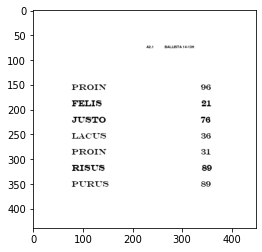

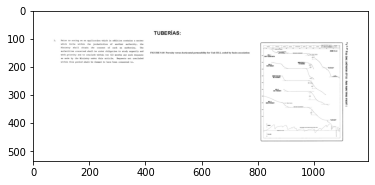

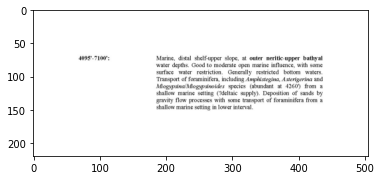

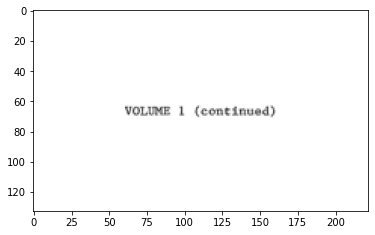

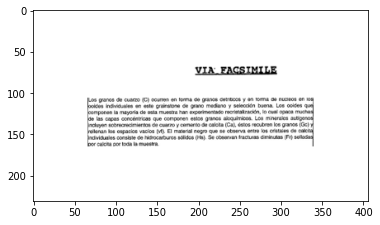

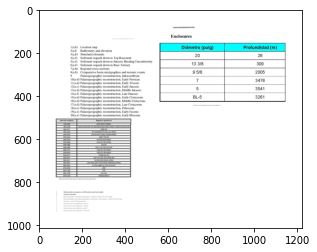

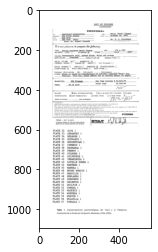

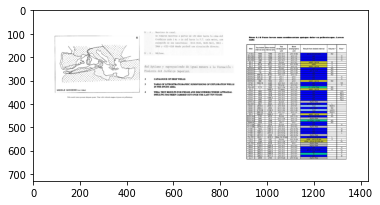

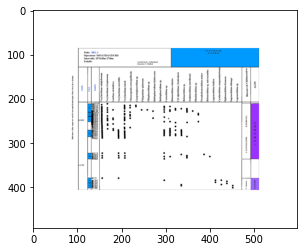

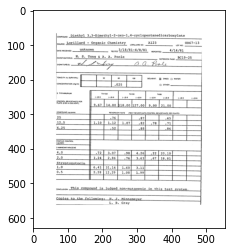

In [108]:
for img in img_lst:
    plt.imshow(img)
    plt.show()

In [ ]:
os.path.exists('/redresearch1/hlai/geolay/tmp/mixed_v5/img_500_geolay_syth_7/annotations/instances.json')


In [ ]:
os.path.exists('/redresearch1/hlai/geolay/tmp/mixed_v5/img_500_geolay_syth_v7/')

In [ ]:
'/redresearch1/hlai/geolay/tmp/mixed_v5/img_500_geolay_syth_7/'=='/redresearch1/hlai/geolay/tmp/mixed_v5/img_500_geolay_syth_v7/'